In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import logit

from src.analysis.state_space import StateSpaceAnalysisSpec
from src.utils import concat_csv_with_indices

In [3]:
sns.set_context("paper", font_scale=1.5)

In [4]:
false_friends_path = "outputs/analogy/inputs/librispeech-train-clean-100/w2v2/false_friends.csv"
state_space_path = "outputs/analogy/inputs/librispeech-train-clean-100/w2v2/state_space_spec.h5"
output_dir = "analogy_figures"

In [15]:
# Grouping variables on experiment results dataframe to select a single run
run_groupers = ["base_model_name", "model_name", "equivalence"]

plot_runs = [(f"w2v2_{i}", "ff_32", "word_broad_10frames_fixedlen25") for i in range(12)] + \
            [(f"w2v2_{i}", "id", "id") for i in range(12)]
# [(f"w2v2_{i}", "discrim-ff_32", "word_broad_10frames_fixedlen25") for i in range(12)] + \

main_plot_run = ("w2v2_8", "ff_32", "word_broad_10frames_fixedlen25")
# choose a vmin, vmax so that all heatmaps have the same color scale
main_plot_vmin, main_plot_vmax = 0.4, 0.9

plot_inflections = ["NNS", "VBZ", "VBD"]

## Load metadata

In [6]:
word_freq_df = pd.read_csv("data/WorldLex_Eng_US.Freq.2.txt", sep="\t", index_col="Word")
# compute weighted average frequency across domains
word_freq_df["BlogFreq_rel"] = word_freq_df.BlogFreq / word_freq_df.BlogFreq.sum()
word_freq_df["TwitterFreq_rel"] = word_freq_df.TwitterFreq / word_freq_df.TwitterFreq.sum()
word_freq_df["NewsFreq_rel"] = word_freq_df.NewsFreq / word_freq_df.NewsFreq.sum()
word_freq_df["Freq"] = word_freq_df[["BlogFreq", "TwitterFreq", "NewsFreq"]].mean(axis=1) \
    * word_freq_df[["BlogFreq", "TwitterFreq", "NewsFreq"]].sum().mean()
word_freq_df["LogFreq"] = np.log10(word_freq_df.Freq)

In [7]:
false_friends_df = pd.read_csv(false_friends_path)

In [72]:
false_friends_df.query("inflection == 'VBD' and not strong")

,inflection,post_divergence,base,base_form,inflected,inflected_form,strong_expected,strong
109,VBD,IH D,i'm,AH M,amid,AH M IH D,D,False
110,VBD,IH D,flew,F L UW,fluid,F L UW IH D,D,False
111,VBD,IH D,ll,L,lid,L IH D,D,False
112,VBD,IH D,live,L IH V,livid,L IH V IH D,D,False
114,VBD,IH D,rap,R AE P,rapid,R AE P IH D,T,False
...,...,...,...,...,...,...,...,...
188,VBD,T,why,W AY,white,W AY T,D,False
189,VBD,T,why,HH W AY,white,HH W AY T,D,False
190,VBD,T,we'll,W IH L,wilt,W IH L T,D,False
192,VBD,T,wooden,W UH D AH N,wouldn't,W UH D AH N T,D,False


## Theoretical generalization matrices

In [8]:
inflections = ["NNS", "VBZ"]
allomorphs = ["Z", "S", "IH Z"]
rows = [{"from_inflection": from_inflection, "from_allomorph": from_allomorph,
            "to_inflection": to_inflection, "to_allomorph": to_allomorph}
        for from_inflection in inflections
        for from_allomorph in allomorphs
        for to_inflection in inflections
        for to_allomorph in allomorphs]

generalization_df = pd.DataFrame(rows)
generalization_df["source_label"] = generalization_df["from_inflection"] + " " + generalization_df["from_allomorph"]
generalization_df["target_label"] = generalization_df["to_inflection"] + " " + generalization_df["to_allomorph"]
generalization_df

,from_inflection,from_allomorph,to_inflection,to_allomorph,source_label,target_label
0,NNS,Z,NNS,Z,NNS Z,NNS Z
1,NNS,Z,NNS,S,NNS Z,NNS S
2,NNS,Z,NNS,IH Z,NNS Z,NNS IH Z
3,NNS,Z,VBZ,Z,NNS Z,VBZ Z
4,NNS,Z,VBZ,S,NNS Z,VBZ S
5,NNS,Z,VBZ,IH Z,NNS Z,VBZ IH Z
6,NNS,S,NNS,Z,NNS S,NNS Z
7,NNS,S,NNS,S,NNS S,NNS S
8,NNS,S,NNS,IH Z,NNS S,NNS IH Z
9,NNS,S,VBZ,Z,NNS S,VBZ Z


In [9]:
phonetic_generalization_df = generalization_df.copy()
phonetic_generalization_df["correct"] = False
phonetic_generalization_df.loc[phonetic_generalization_df.from_allomorph == phonetic_generalization_df.to_allomorph, "correct"] = True

<Axes: xlabel='target_label', ylabel='source_label'>

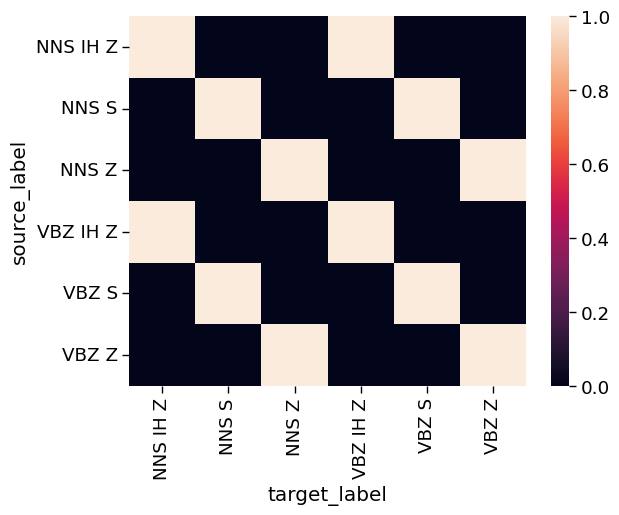

In [10]:
sns.heatmap(phonetic_generalization_df.set_index(["source_label", "target_label"]).correct.unstack())

In [11]:
morphological_generalization_df = generalization_df.copy()
morphological_generalization_df["correct"] = False
morphological_generalization_df.loc[phonetic_generalization_df.from_inflection == phonetic_generalization_df.to_inflection, "correct"] = True

<Axes: xlabel='target_label', ylabel='source_label'>

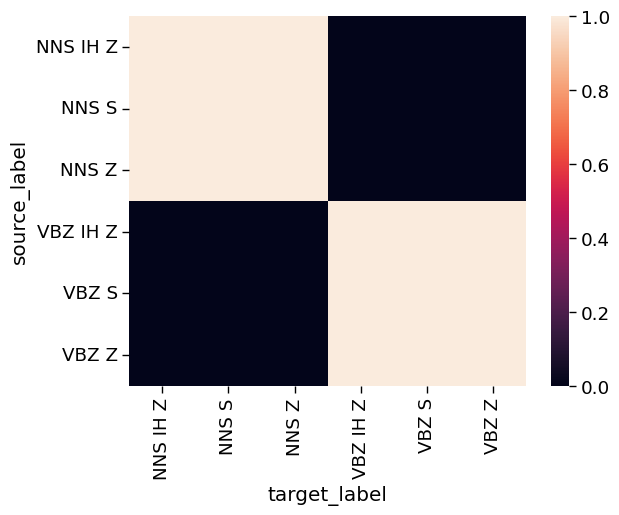

In [12]:
sns.heatmap(morphological_generalization_df.set_index(["source_label", "target_label"]).correct.unstack())

In [13]:
metaphon_generalization_df = generalization_df.copy()
metaphon_generalization_df["correct"] = True

<Axes: xlabel='target_label', ylabel='source_label'>

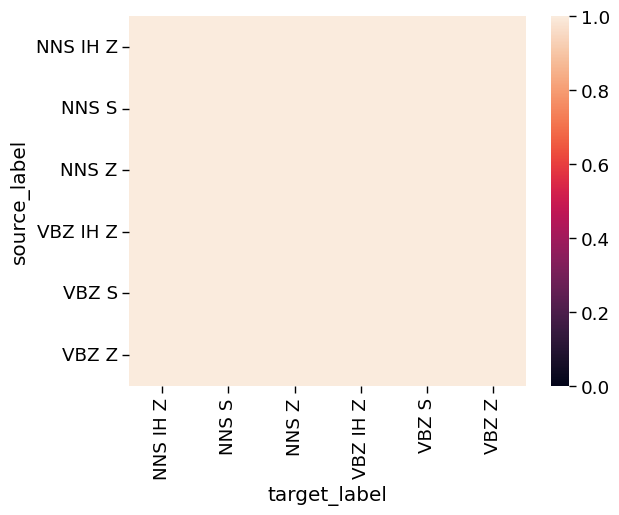

In [14]:
sns.heatmap(metaphon_generalization_df.set_index(["source_label", "target_label"]).correct.unstack(),
            vmin=0, vmax=1)

### With false friends

In [15]:
inflections = ["NNS", "VBZ"]
allomorphs = ["Z", "S", "IH Z"]
rows = [{"from_inflection_base": from_inflection, "from_allomorph": from_allomorph,
         "to_inflection_base": to_inflection, "to_allomorph": to_allomorph,
         "ff_from": ff_from, "ff_to": ff_to}
        for from_inflection in inflections
        for from_allomorph in allomorphs
        for to_inflection in inflections
        for to_allomorph in allomorphs
        for ff_from in [False, True]
        for ff_to in [False, True]]

ff_generalization_df = pd.DataFrame(rows)
ff_generalization_df["from_inflection"] = ff_generalization_df["from_inflection_base"] + ff_generalization_df.ff_from.map({False: "", True: "-FF"})
ff_generalization_df["to_inflection"] = ff_generalization_df["to_inflection_base"] + ff_generalization_df.ff_to.map({False: "", True: "-FF"})
ff_generalization_df["source_label"] = ff_generalization_df["from_inflection"] + " " + ff_generalization_df["from_allomorph"]
ff_generalization_df["target_label"] = ff_generalization_df["to_inflection"] + " " + ff_generalization_df["to_allomorph"]
ff_generalization_df

,from_inflection_base,from_allomorph,to_inflection_base,to_allomorph,ff_from,ff_to,from_inflection,to_inflection,source_label,target_label
0,NNS,Z,NNS,Z,False,False,NNS,NNS,NNS Z,NNS Z
1,NNS,Z,NNS,Z,False,True,NNS,NNS-FF,NNS Z,NNS-FF Z
2,NNS,Z,NNS,Z,True,False,NNS-FF,NNS,NNS-FF Z,NNS Z
3,NNS,Z,NNS,Z,True,True,NNS-FF,NNS-FF,NNS-FF Z,NNS-FF Z
4,NNS,Z,NNS,S,False,False,NNS,NNS,NNS Z,NNS S
...,...,...,...,...,...,...,...,...,...,...
139,VBZ,IH Z,VBZ,S,True,True,VBZ-FF,VBZ-FF,VBZ-FF IH Z,VBZ-FF S
140,VBZ,IH Z,VBZ,IH Z,False,False,VBZ,VBZ,VBZ IH Z,VBZ IH Z
141,VBZ,IH Z,VBZ,IH Z,False,True,VBZ,VBZ-FF,VBZ IH Z,VBZ-FF IH Z
142,VBZ,IH Z,VBZ,IH Z,True,False,VBZ-FF,VBZ,VBZ-FF IH Z,VBZ IH Z


In [16]:
ff_phonetic_generalization_df = ff_generalization_df.copy()
ff_phonetic_generalization_df["correct"] = False
ff_phonetic_generalization_df.loc[ff_phonetic_generalization_df.from_allomorph == ff_phonetic_generalization_df.to_allomorph, "correct"] = True

<Axes: xlabel='target_label', ylabel='source_label'>

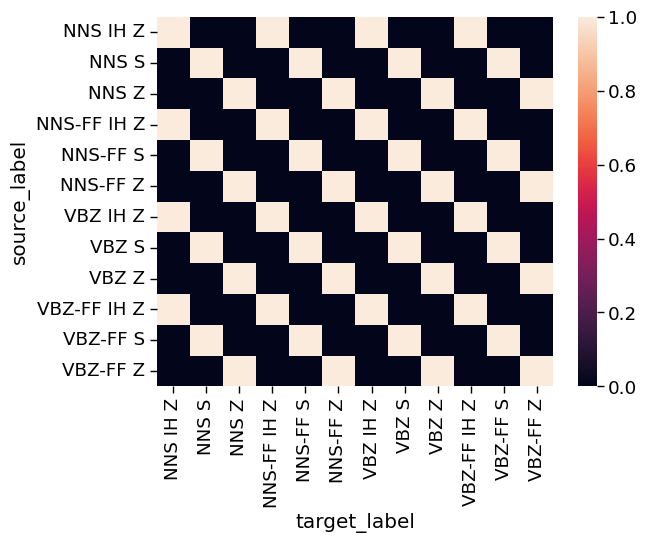

In [17]:
sns.heatmap(ff_phonetic_generalization_df.set_index(["source_label", "target_label"]).correct.unstack())

In [18]:
ff_morphological_generalization_df = ff_generalization_df.copy()
ff_morphological_generalization_df["correct"] = False
ff_morphological_generalization_df.loc[(ff_phonetic_generalization_df.from_inflection == ff_phonetic_generalization_df.to_inflection)
                                       & ~ff_phonetic_generalization_df.from_inflection.str.contains("-FF"), "correct"] = True

<Axes: xlabel='target_label', ylabel='source_label'>

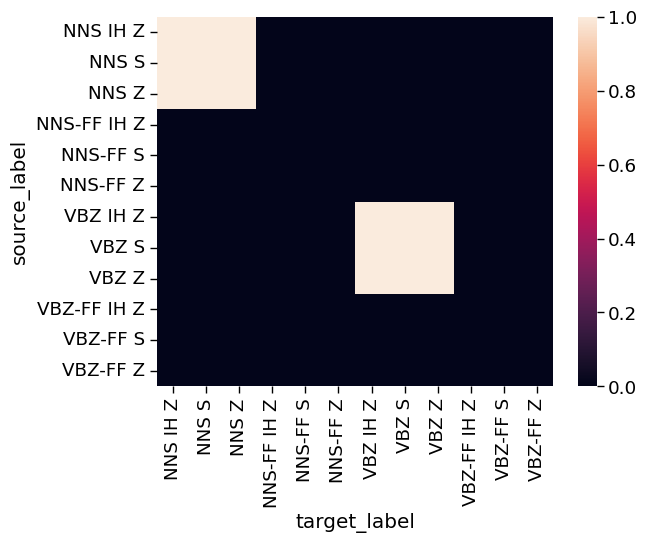

In [19]:
sns.heatmap(ff_morphological_generalization_df.set_index(["source_label", "target_label"]).correct.unstack())

In [20]:
ff_metaphon_generalization_df = ff_generalization_df.copy()
ff_metaphon_generalization_df["correct"] = 0.3
ff_metaphon_generalization_df.loc[~ff_metaphon_generalization_df.ff_from &
                                  ~ff_metaphon_generalization_df.ff_to, "correct"] = 1.0

<Axes: xlabel='target_label', ylabel='source_label'>

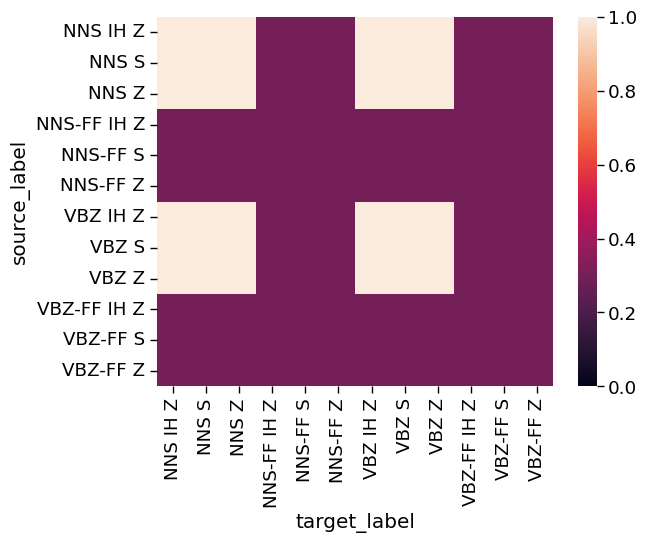

In [21]:
sns.heatmap(ff_metaphon_generalization_df.set_index(["source_label", "target_label"]).correct.unstack(),
            vmin=0, vmax=1)

## Load results

In [8]:
all_results = concat_csv_with_indices(
        "outputs/analogy/runs/**/experiment_results.csv",
        [lambda p: p.parent.name, lambda p: p.parents[1].name,
            lambda p: p.parents[2].name],
        ["equivalence", "model_name", "base_model_name"]) \
    .droplevel(-1).reset_index()

/userdata/jgauthier/projects/ideal-word-representations/src/utils/__init__.py:38: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [reader(p, **kwargs) for p in paths]
/userdata/jgauthier/projects/ideal-word-representations/src/utils/__init__.py:38: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [reader(p, **kwargs) for p in paths]
/userdata/jgauthier/projects/ideal-word-representations/src/utils/__init__.py:38: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [reader(p, **kwargs) for p in paths]
/userdata/jgauthier/projects/ideal-word-representations/src/utils/__init__.py:38: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [reader(p, **kwargs) for p in paths]
/userdata/jgauthier/projects/ideal-word-representations/src/utils/__init__.py:38: DtypeWarni

In [9]:
all_id_results = concat_csv_with_indices(
        "outputs/analogy/runs_id/**/experiment_results.csv",
        [lambda p: p.parent.name],
        ["base_model_name"]) \
    .droplevel(-1).reset_index()
all_id_results["model_name"] = "id"
all_id_results["equivalence"] = "id"

/userdata/jgauthier/projects/ideal-word-representations/src/utils/__init__.py:38: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [reader(p, **kwargs) for p in paths]
/userdata/jgauthier/projects/ideal-word-representations/src/utils/__init__.py:38: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [reader(p, **kwargs) for p in paths]
/userdata/jgauthier/projects/ideal-word-representations/src/utils/__init__.py:38: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [reader(p, **kwargs) for p in paths]
/userdata/jgauthier/projects/ideal-word-representations/src/utils/__init__.py:38: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [reader(p, **kwargs) for p in paths]
/userdata/jgauthier/projects/ideal-word-representations/src/utils/__init__.py:38: DtypeWarni

In [10]:
all_results = pd.concat([all_results, all_id_results], ignore_index=True)
all_results["group"] = all_results.group.apply(lambda x: eval(x) if not (isinstance(x, float) and np.isnan(x)) else None)

In [11]:
all_results

,equivalence,model_name,base_model_name,experiment,Unnamed: 1,group,from_equiv_label,to_equiv_label,base_from,base_to,inflection_from,inflection_to,predicted_label_idx,predicted_label,predicted_instance_idx,gt_label,gt_label_idx,gt_label_rank,gt_distance,correct
0,word_broad_10frames_fixedlen25,ff_32,w2v2_9,basic,0,"(NNS,)","('model', 'models')","('dog', 'dogs')",model,dog,NNS,NNS,1789,dogs,20,dogs,1789,0,0.219663,True
1,word_broad_10frames_fixedlen25,ff_32,w2v2_9,basic,1,"(NNS,)","('shelf', 'shelves')","('boundary', 'boundaries')",shelf,boundary,NNS,NNS,3106,bamboo,2,boundaries,4699,10,0.543584,False
2,word_broad_10frames_fixedlen25,ff_32,w2v2_9,basic,2,"(NNS,)","('principle', 'principles')","('row', 'rows')",principle,row,NNS,NNS,3324,road,93,rows,6582,4,0.978438,False
3,word_broad_10frames_fixedlen25,ff_32,w2v2_9,basic,3,"(NNS,)","('objection', 'objections')","('common', 'commons')",objection,common,NNS,NNS,13952,commons,21,commons,13952,0,0.837475,True
4,word_broad_10frames_fixedlen25,ff_32,w2v2_9,basic,4,"(NNS,)","('platform', 'platforms')","('prospect', 'prospects')",platform,prospect,NNS,NNS,5437,prospects,6,prospects,5437,0,0.972313,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054891,id,id,w2v2_1,VBZ-FF-S-to-VBZ-FF-IH Z,36,None,"('meek', 'meeks')","('rich', 'riches')",meek,rich,VBZ-FF-S,VBZ-FF-IH Z,8246,searched,17,riches,4671,54,0.882700,False
3054892,id,id,w2v2_1,VBZ-FF-S-to-VBZ-FF-IH Z,37,None,"('far', 'farce')","('rich', 'riches')",far,rich,VBZ-FF-S,VBZ-FF-IH Z,885,directions,12,riches,4671,200,0.795613,False
3054893,id,id,w2v2_1,VBZ-FF-S-to-VBZ-FF-IH Z,38,None,"('jew', 'juice')","('rich', 'riches')",jew,rich,VBZ-FF-S,VBZ-FF-IH Z,543,ships,33,riches,4671,37,0.892454,False
3054894,id,id,w2v2_1,VBZ-FF-S-to-VBZ-FF-IH Z,39,None,"('really', 'release')","('rich', 'riches')",really,rich,VBZ-FF-S,VBZ-FF-IH Z,1881,distress,20,riches,4671,65,0.797634,False


In [26]:
!ls -lh analogy_results_20250217.pkl

-rw-r--r-- 1 jgauthier c_lab 233M Feb 17 12:07 analogy_results_20250217.pkl


### Layer-wise

In [16]:
plot_lw = all_results.query("experiment == 'regular'").copy()
plot_lw = plot_lw.groupby(run_groupers + ["group", "inflection_from"]).correct.mean()
plot_lw = plot_lw.reindex([(*plot_run, group, inflection_from)
                           for group in plot_lw.index.get_level_values("group").unique()
                           for inflection_from in plot_lw.index.get_level_values("inflection_from").unique()
                           for plot_run in plot_runs]).reset_index()
plot_lw["group0"] = plot_lw.group.apply(lambda x: x[0] if x is not None else None)
plot_lw["group1"] = plot_lw.group.apply(lambda x: x[1] if x is not None else None)
plot_lw["layer"] = plot_lw.base_model_name.str.extract(r"_(\d+)$").astype(int)

lw_random = plot_lw[plot_lw.group0 == "random"].groupby(["inflection_from", "layer"]).correct.mean().reset_index().dropna()

plot_lw = plot_lw[plot_lw.inflection_from.isin(plot_inflections)]
plot_lw = plot_lw[(plot_lw.group1 == True)]

In [17]:
lw_random

,inflection_from,layer,correct
60,random,0,0.0000
61,random,1,0.0000
62,random,2,0.0005
63,random,3,0.0000
64,random,4,0.0000
65,random,5,0.0000
66,random,6,0.0000
67,random,7,0.0000
68,random,8,0.0000
69,random,9,0.0000


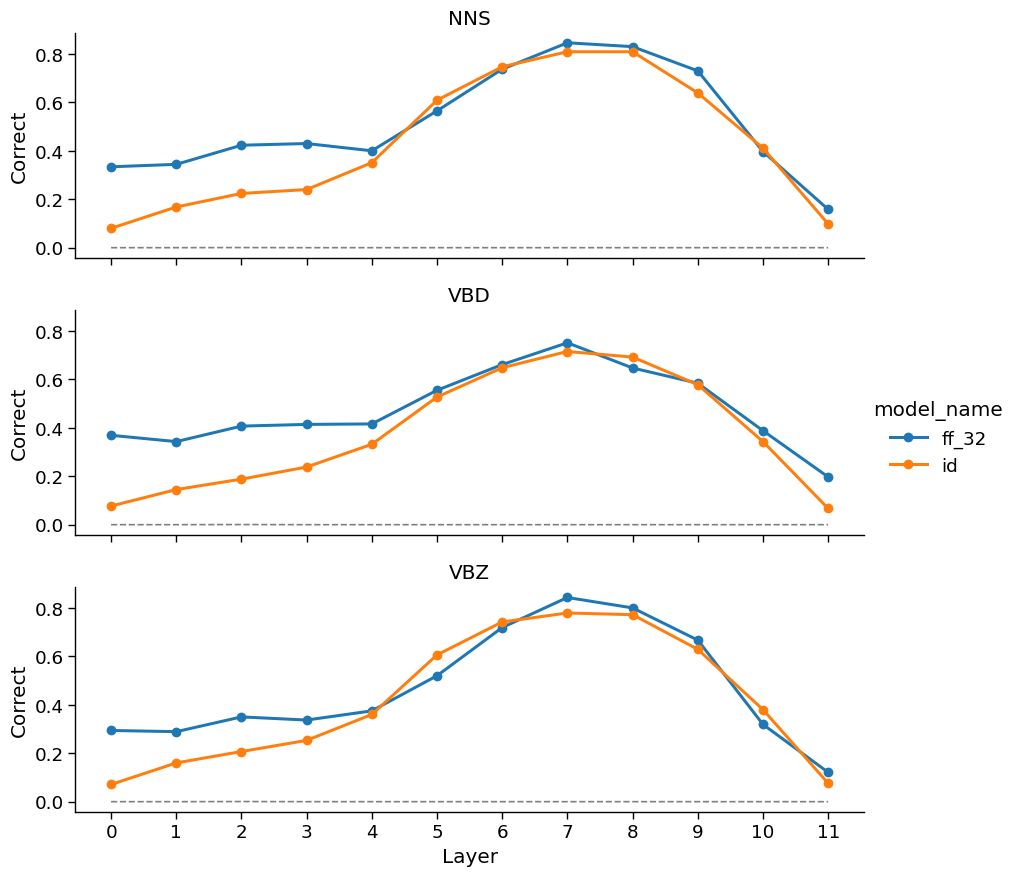

In [18]:
g = sns.catplot(data=plot_lw, x="layer", y="correct", hue="model_name", row="inflection_from",
                kind="point", height=3, aspect=3)

for ax, row_name in zip(g.axes.flat, g.row_names):
    sns.lineplot(data=lw_random,
                 x="layer", y="correct", ax=ax, color="gray", linestyle="--",
                 legend=None)
    ax.set_title(ax.get_title().split("=")[1].strip())
    ax.set_ylabel("Correct")
    if ax.get_xlabel() == "layer":
        ax.set_xlabel("Layer")

# g.figure.tight_layout()
g.figure.savefig(f"{output_dir}/layer_wise.pdf")

In [38]:
mca = pd.read_csv("outputs/analogy/inputs/librispeech-train-clean-100/w2v2/most_common_allomorphs.csv", index_col=0)
mca.query("inflection == 'VBD'")

,inflection,base,most_common_allomorph
1213,VBD,abandon,D
1214,VBD,accent,IH D
1215,VBD,accept,AH D
1216,VBD,accompany,D
1217,VBD,accomplish,T
...,...,...,...
2149,VBD,wound,IH D
2150,VBD,wreck,T
2151,VBD,write,OW T
2152,VBD,yell,D


allomorph_from  allomorph_to
D               D               17480
                T                8588
T               D                8056
IH D            D                7942
D               IH D             7676
                                ...  
UW N D          AH D               38
                AO R               38
                AO T               38
                AW N D             38
UW              OW N               38
Name: count, Length: 1013, dtype: int64

## Compute controlled NNVB results

In [19]:
all_nnvb_results = []

for run, run_results in all_results.groupby(run_groupers):
    run_results = run_results.set_index("experiment")
    nnvb_expts = run_results.index.unique()
    nnvb_expts = nnvb_expts[nnvb_expts.str.contains("unambiguous-")]

    for expt in nnvb_expts:
        inflection_from, allomorph_from, inflection_to, allomorph_to = \
            re.findall(r"unambiguous-(\w+)_([\w\s]+)_to_(\w+)_([\w\s]+)", expt)[0]
        expt_df = run_results.loc[expt].copy()

        num_seen_words = min(len(expt_df.base_from.unique()), len(expt_df.base_to.unique()))
        # DEV
        # if num_seen_words < 10:
        #     print(f"Skipping {expt} due to only {num_seen_words} seen words")
        #     continue

        expt_df["inflection_from"] = inflection_from
        expt_df["allomorph_from"] = allomorph_from
        expt_df["inflection_to"] = inflection_to
        expt_df["allomorph_to"] = allomorph_to

        all_nnvb_results.append(expt_df)

all_nnvb_results = pd.concat(all_nnvb_results)

all_nnvb_results["inflected_from"] = all_nnvb_results.from_equiv_label.apply(lambda x: eval(x)[1])
all_nnvb_results["inflected_to"] = all_nnvb_results.to_equiv_label.apply(lambda x: eval(x)[1])

all_nnvb_results = pd.merge(all_nnvb_results, word_freq_df.LogFreq.rename("from_base_freq"),
                            left_on="base_from", right_index=True)
all_nnvb_results = pd.merge(all_nnvb_results, word_freq_df.LogFreq.rename("from_inflected_freq"),
                            left_on="inflected_from", right_index=True)
all_nnvb_results = pd.merge(all_nnvb_results, word_freq_df.LogFreq.rename("to_base_freq"),
                              left_on="base_to", right_index=True)
all_nnvb_results = pd.merge(all_nnvb_results, word_freq_df.LogFreq.rename("to_inflected_freq"),
                            left_on="inflected_to", right_index=True)

all_nnvb_results["from_freq"] = all_nnvb_results[["from_base_freq", "from_inflected_freq"]].mean(axis=1)
all_nnvb_results["to_freq"] = all_nnvb_results[["to_base_freq", "to_inflected_freq"]].mean(axis=1)

_, frequency_bins = pd.qcut(pd.concat([all_nnvb_results.to_freq, all_nnvb_results.from_freq]), q=5, retbins=True)
all_nnvb_results["to_freq_bin"] = pd.cut(all_nnvb_results.to_freq, bins=frequency_bins, labels=[f"Q{i}" for i in range(1, 6)])
all_nnvb_results["from_freq_bin"] = pd.cut(all_nnvb_results.from_freq, bins=frequency_bins, labels=[f"Q{i}" for i in range(1, 6)])

In [20]:
def summarize_nnvb_run(rows):
    rows["source_label"] = rows.inflection_from + " " + rows.allomorph_from
    rows["target_label"] = rows.inflection_to + " " + rows.allomorph_to

    rows["transfer_label"] = rows.inflection_from + " -> " + rows.inflection_to
    rows["phon_label"] = rows.allomorph_from + " " + rows.allomorph_to

    # only retain cases where we have data in both transfer directions from source <-> target within inflection
    rows["complement_exists"] = rows.apply(lambda row: len(rows.query("source_label == @row.target_label and target_label == @row.source_label")), axis=1)
    rows = rows.query("complement_exists > 0").drop(columns=["complement_exists"])

    return rows

summary_groupers = ["inflection_from", "inflection_to", "allomorph_from", "allomorph_to"]
nnvb_results_summary = all_nnvb_results.groupby(run_groupers + summary_groupers) \
    .correct.agg(["count", "mean"]) \
    .query("count >= 0") \
    .reset_index(summary_groupers) \
    .groupby(run_groupers, group_keys=False) \
    .apply(summarize_nnvb_run) \
    .reset_index()

nnvb_results_summary

,base_model_name,model_name,equivalence,inflection_from,inflection_to,allomorph_from,allomorph_to,count,mean,source_label,target_label,transfer_label,phon_label
0,w2v2_0,discrim-ff_32,word_broad_10frames_fixedlen25,NNS,NNS,IH Z,IH Z,1000,0.072000,NNS IH Z,NNS IH Z,NNS -> NNS,IH Z IH Z
1,w2v2_0,discrim-ff_32,word_broad_10frames_fixedlen25,NNS,NNS,IH Z,S,1000,0.019000,NNS IH Z,NNS S,NNS -> NNS,IH Z S
2,w2v2_0,discrim-ff_32,word_broad_10frames_fixedlen25,NNS,NNS,IH Z,Z,1000,0.045000,NNS IH Z,NNS Z,NNS -> NNS,IH Z Z
3,w2v2_0,discrim-ff_32,word_broad_10frames_fixedlen25,NNS,NNS,S,IH Z,1000,0.016000,NNS S,NNS IH Z,NNS -> NNS,S IH Z
4,w2v2_0,discrim-ff_32,word_broad_10frames_fixedlen25,NNS,NNS,S,S,1000,0.052000,NNS S,NNS S,NNS -> NNS,S S
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1363,w2v2_pc_8,discrim-rnn_32-pc-mAP1,word_broad_10frames_fixedlen25,VBZ,VBZ,S,S,182,0.445055,VBZ S,VBZ S,VBZ -> VBZ,S S
1364,w2v2_pc_8,discrim-rnn_32-pc-mAP1,word_broad_10frames_fixedlen25,VBZ,VBZ,S,Z,560,0.487500,VBZ S,VBZ Z,VBZ -> VBZ,S Z
1365,w2v2_pc_8,discrim-rnn_32-pc-mAP1,word_broad_10frames_fixedlen25,VBZ,VBZ,Z,IH Z,160,0.231250,VBZ Z,VBZ IH Z,VBZ -> VBZ,Z IH Z
1366,w2v2_pc_8,discrim-rnn_32-pc-mAP1,word_broad_10frames_fixedlen25,VBZ,VBZ,Z,S,560,0.389286,VBZ Z,VBZ S,VBZ -> VBZ,Z S


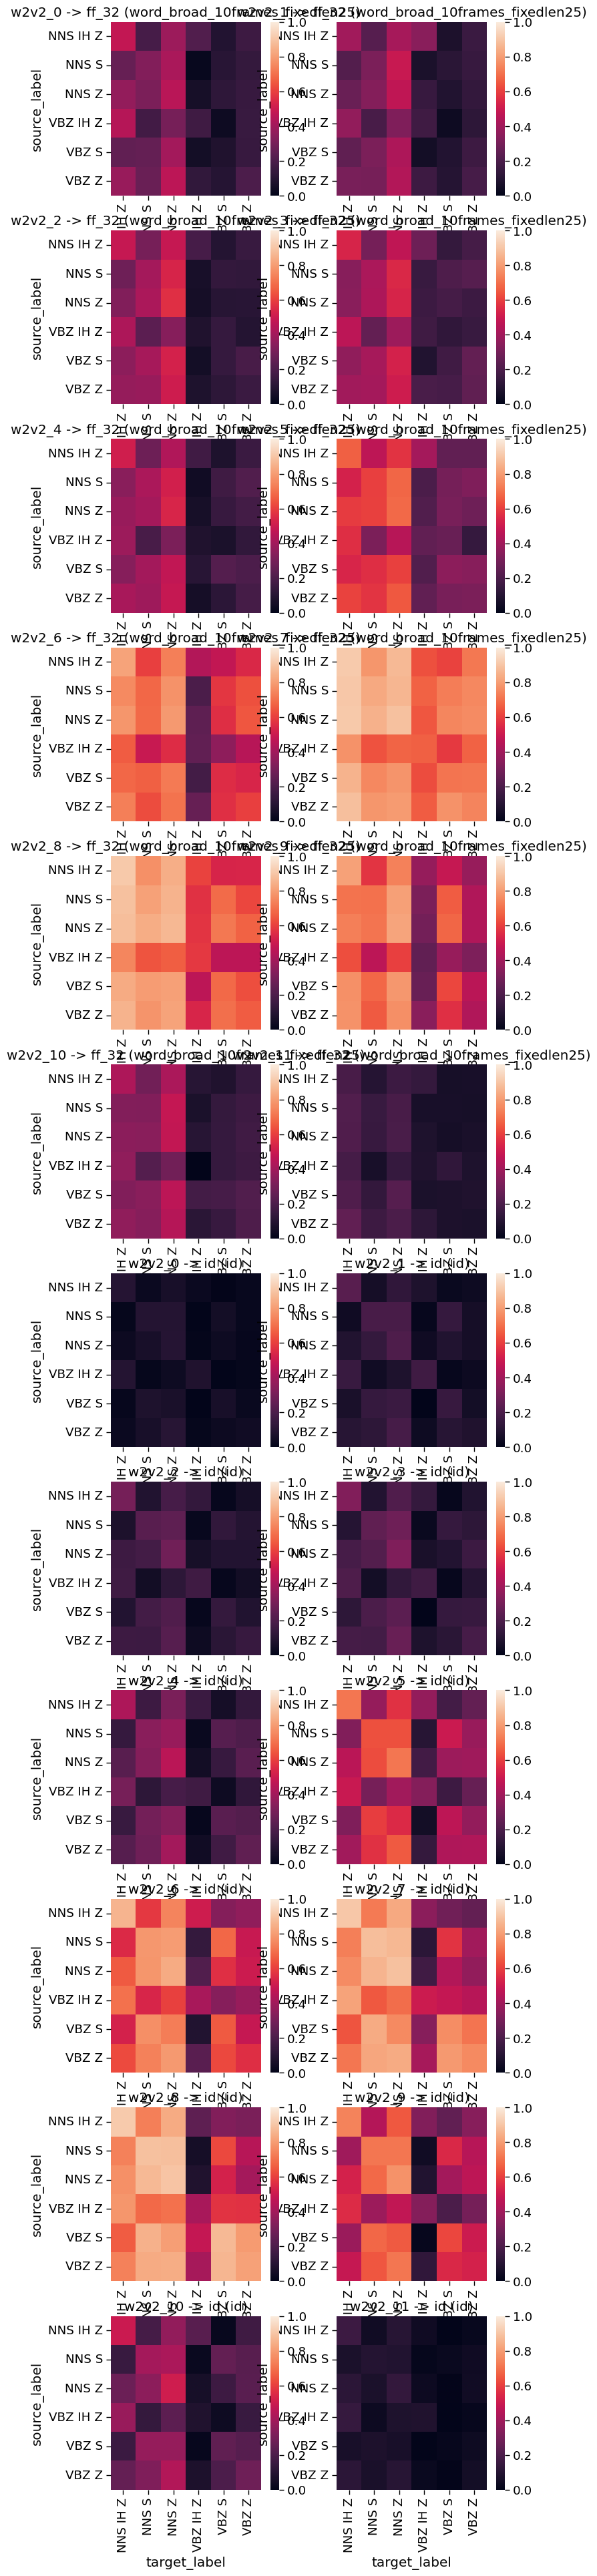

In [21]:
plot_results = []
for base_model_name, model_name, equivalence in plot_runs:
    results_i = nnvb_results_summary.query("base_model_name == @base_model_name and model_name == @model_name and equivalence == @equivalence")
    if len(results_i) > 0:
        plot_results.append(results_i)
num_plot_runs = len(plot_results)

ncols = 2
nrows = int(np.ceil(num_plot_runs / ncols))
f, axs = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))

for ax, results_i in zip(axs.flat, plot_results):
    sns.heatmap(results_i.set_index(["source_label", "target_label"])["mean"].unstack(),
                vmin=0, vmax=1, ax=ax)
    key_row = results_i.iloc[0]
    ax.set_title(f"{key_row.base_model_name} -> {key_row.model_name} ({key_row.equivalence})")

### Focused plots

In [22]:
focus_base_model, focus_model, focus_equivalence = main_plot_run
foil_base_model, foil_model, foil_equivalence = "w2v2_8", "id", "id"

nnvb_focus = all_nnvb_results.query("base_model_name == @focus_base_model and model_name == @focus_model and equivalence == @focus_equivalence")
nnvb_foil = all_nnvb_results.query("base_model_name == @foil_base_model and model_name == @foil_model and equivalence == @foil_equivalence")
nnvb_focus["model_label"] = "Word"
nnvb_foil["model_label"] = "Wav2Vec"

nnvb_focus = pd.concat([nnvb_focus, nnvb_foil])

allomorph_labels = {"Z": "z", "S": "s", "IH Z": "ɪz"}
nnvb_focus["allomorph_from"] = nnvb_focus.allomorph_from.map(allomorph_labels)
nnvb_focus["allomorph_to"] = nnvb_focus.allomorph_to.map(allomorph_labels)
nnvb_focus

/tmp/ipykernel_1658110/3874715788.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nnvb_focus["model_label"] = "Word"
/tmp/ipykernel_1658110/3874715788.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nnvb_foil["model_label"] = "Wav2Vec"


,equivalence,model_name,base_model_name,Unnamed: 1,group,from_equiv_label,to_equiv_label,base_from,base_to,inflection_from,...,inflected_to,from_base_freq,from_inflected_freq,to_base_freq,to_inflected_freq,from_freq,to_freq,to_freq_bin,from_freq_bin,model_label
experiment,,,,,,,,,,,,,,,,,,,,,
unambiguous-NNS_Z_to_NNS_Z,word_broad_10frames_fixedlen25,ff_32,w2v2_8,0,None,"('champion', 'champions')","('sister', 'sisters')",champion,sister,NNS,...,sisters,10.616698,10.312125,11.101817,10.575098,10.464411,10.838458,Q4,Q3,Word
unambiguous-NNS_Z_to_NNS_Z,word_broad_10frames_fixedlen25,ff_32,w2v2_8,1,None,"('vision', 'visions')","('year', 'years')",vision,year,NNS,...,years,10.714653,9.870331,12.146887,12.033642,10.292492,12.090264,Q5,Q3,Word
unambiguous-NNS_Z_to_NNS_Z,word_broad_10frames_fixedlen25,ff_32,w2v2_8,2,None,"('mosquito', 'mosquitoes')","('obstacle', 'obstacles')",mosquito,obstacle,NNS,...,obstacles,9.522033,9.423987,9.814660,9.998145,9.473010,9.906402,Q2,Q1,Word
unambiguous-NNS_Z_to_NNS_Z,word_broad_10frames_fixedlen25,ff_32,w2v2_8,3,None,"('individual', 'individuals')","('contemporary', 'contemporaries')",individual,contemporary,NNS,...,contemporaries,10.899842,10.676617,10.484602,9.302198,10.788230,9.893400,Q2,Q4,Word
unambiguous-NNS_Z_to_NNS_Z,word_broad_10frames_fixedlen25,ff_32,w2v2_8,4,None,"('grave', 'graves')","('energy', 'energies')",grave,energy,NNS,...,energies,10.178762,9.816200,11.227253,9.606977,9.997481,10.417115,Q3,Q2,Word
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
unambiguous-VBZ_IH Z_to_VBZ_IH Z,id,id,w2v2_8,7,None,"('possess', 'possesses')","('please', 'pleases')",possess,please,VBZ,...,pleases,9.916021,9.477451,11.690215,9.321830,9.696736,10.506022,Q3,Q1,Wav2Vec
unambiguous-VBZ_IH Z_to_VBZ_IH Z,id,id,w2v2_8,8,None,"('do', 'does')","('please', 'pleases')",do,please,VBZ,...,pleases,12.447336,11.782977,11.690215,9.321830,12.115157,10.506022,Q3,Q5,Wav2Vec
unambiguous-VBZ_IH Z_to_VBZ_IH Z,id,id,w2v2_8,9,None,"('please', 'pleases')","('do', 'does')",please,do,VBZ,...,does,11.690215,9.321830,12.447336,11.782977,10.506022,12.115157,Q5,Q3,Wav2Vec


In [23]:
nnvb_results_summary = nnvb_focus.groupby(["model_label", "inflection_from", "inflection_to",
                                             "allomorph_from", "allomorph_to"]) \
    .correct.agg(["count", "mean"]) \
    .query("count >= 0") \
    .reset_index()

nnvb_results_summary["source_label"] = nnvb_results_summary.inflection_from + "\n" + nnvb_results_summary.allomorph_from
nnvb_results_summary["target_label"] = nnvb_results_summary.inflection_to + "\n" + nnvb_results_summary.allomorph_to

nnvb_results_summary["transfer_label"] = nnvb_results_summary.inflection_from + " -> " + nnvb_results_summary.inflection_to
nnvb_results_summary["phon_label"] = nnvb_results_summary.allomorph_from + " " + nnvb_results_summary.allomorph_to

# only retain cases where we have data in both transfer directions from source <-> target within inflection
nnvb_results_summary["complement_exists"] = nnvb_results_summary.apply(lambda row: len(nnvb_results_summary.query("source_label == @row.target_label and target_label == @row.source_label")), axis=1)
nnvb_results_summary = nnvb_results_summary.query("complement_exists > 0").drop(columns=["complement_exists"])

# drop VBZ IH Z, which only has 4 word types
nnvb_results_summary = nnvb_results_summary[(nnvb_results_summary.source_label != "VBZ\nɪz") & (nnvb_results_summary.target_label != "VBZ\nɪz")]

nnvb_results_summary

,model_label,inflection_from,inflection_to,allomorph_from,allomorph_to,count,mean,source_label,target_label,transfer_label,phon_label
0,Wav2Vec,NNS,NNS,s,s,1000,0.890000,NNS\ns,NNS\ns,NNS -> NNS,s s
1,Wav2Vec,NNS,NNS,s,z,1000,0.883000,NNS\ns,NNS\nz,NNS -> NNS,s z
2,Wav2Vec,NNS,NNS,s,ɪz,1000,0.736000,NNS\ns,NNS\nɪz,NNS -> NNS,s ɪz
3,Wav2Vec,NNS,NNS,z,s,1000,0.868000,NNS\nz,NNS\ns,NNS -> NNS,z s
4,Wav2Vec,NNS,NNS,z,z,1000,0.898000,NNS\nz,NNS\nz,NNS -> NNS,z z
5,Wav2Vec,NNS,NNS,z,ɪz,1000,0.772000,NNS\nz,NNS\nɪz,NNS -> NNS,z ɪz
6,Wav2Vec,NNS,NNS,ɪz,s,1000,0.732000,NNS\nɪz,NNS\ns,NNS -> NNS,ɪz s
7,Wav2Vec,NNS,NNS,ɪz,z,1000,0.835000,NNS\nɪz,NNS\nz,NNS -> NNS,ɪz z
8,Wav2Vec,NNS,NNS,ɪz,ɪz,1000,0.911000,NNS\nɪz,NNS\nɪz,NNS -> NNS,ɪz ɪz
9,Wav2Vec,NNS,VBZ,s,s,1000,0.620000,NNS\ns,VBZ\ns,NNS -> VBZ,s s


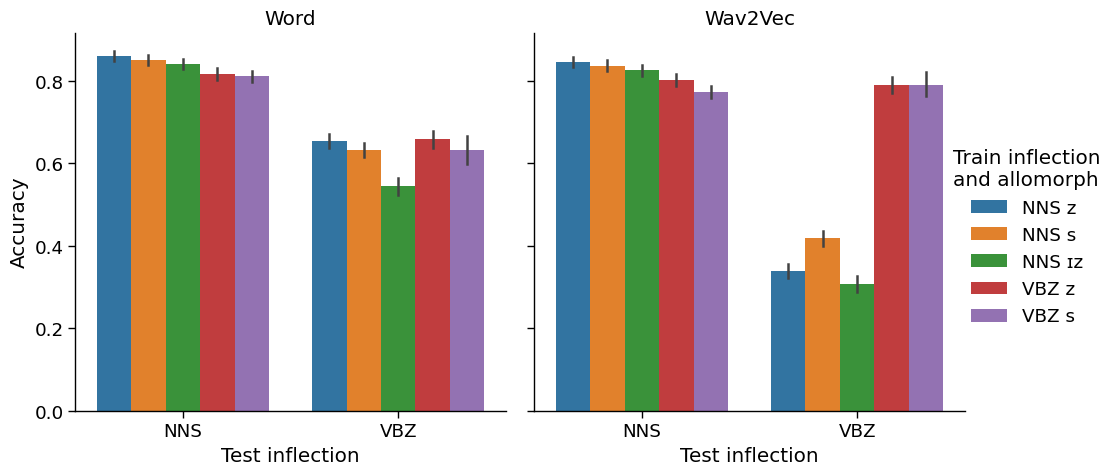

In [24]:
nnvb_focus_bar = nnvb_focus.assign(source_label=lambda xs: xs.inflection_from + " " + xs.allomorph_from)
nnvb_focus_bar = nnvb_focus_bar[(nnvb_focus_bar.source_label != "VBZ ɪz")]
order = nnvb_focus_bar.groupby("source_label").correct.mean().sort_values().index
g = sns.catplot(data=nnvb_focus_bar, x="inflection_to", hue="source_label", y="correct", col="model_label", kind="bar")
g._legend.set_title("Train inflection\nand allomorph")

for ax in g.axes.flat:
    ax.set_title(ax.get_title().split("=")[1].strip())
    ax.set_xlabel("Test inflection")
    ax.set_ylabel("Accuracy")

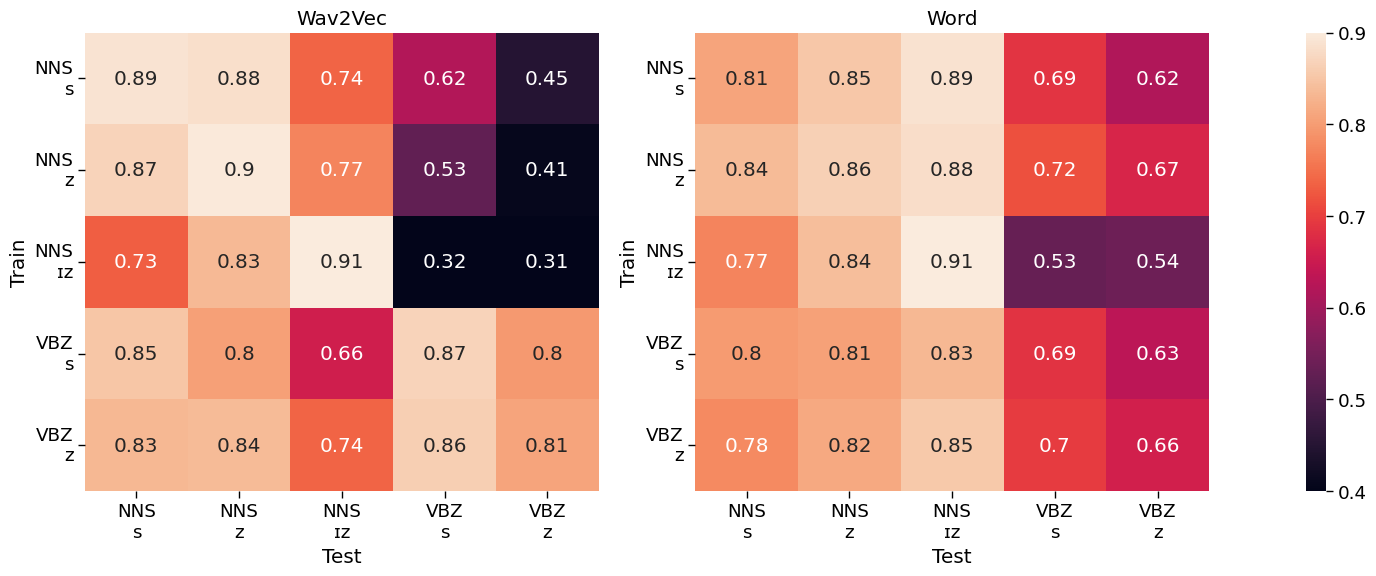

In [25]:
# f, ax = plt.subplots(1, 2, figsize=(7 * 2, 6))

f, axs = plt.subplots(1, 3, figsize=(7 * 2, 6), gridspec_kw={'width_ratios': [1, 1, 0.04]})
for i, (ax, (model_label, rows)) in enumerate(zip(axs, nnvb_results_summary.groupby("model_label"))):
    cbar_ax = None
    if i == 1:
        cbar_ax = axs.flat[-1]

    ax.set_title(model_label)
    sns.heatmap(rows.set_index(["source_label", "target_label"]).sort_index()["mean"].unstack("target_label"),
                vmin=main_plot_vmin, vmax=main_plot_vmax, annot=True, ax=ax,
                cbar=i == 1, cbar_ax=cbar_ax)

    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_ylabel("Train")
    ax.set_xlabel("Test")

f.tight_layout()
f.savefig(f"{output_dir}/nnvb_allomorphs.pdf")

In [26]:
nnvb_results_summary2 = nnvb_focus.groupby(["model_label", "inflection_from", "inflection_to"]) \
    [["correct", "gt_label_rank", "gt_distance"]].mean().reset_index()

nnvb_results_summary2["transfer_label"] = nnvb_results_summary2.inflection_from + " -> " + nnvb_results_summary2.inflection_to
nnvb_results_summary2

,model_label,inflection_from,inflection_to,correct,gt_label_rank,gt_distance,transfer_label
0,Wav2Vec,NNS,NNS,0.836111,6.324000,0.833854,NNS -> NNS
1,Wav2Vec,NNS,VBZ,0.356942,70.623022,0.816985,NNS -> VBZ
2,Wav2Vec,VBZ,NNS,0.768249,24.803216,0.837957,VBZ -> NNS
3,Wav2Vec,VBZ,VBZ,0.770940,36.068463,0.825766,VBZ -> VBZ
4,Word,NNS,NNS,0.850667,0.694667,1.154509,NNS -> NNS
5,Word,NNS,VBZ,0.615875,8.690020,1.061363,NNS -> VBZ
6,Word,VBZ,NNS,0.778203,2.203931,1.151698,VBZ -> NNS
7,Word,VBZ,VBZ,0.635834,5.902039,1.048129,VBZ -> VBZ


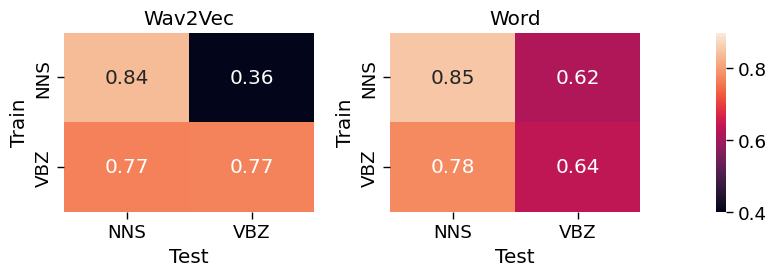

In [27]:
f, axs = plt.subplots(1, 3, figsize=(4 * 2, 3), gridspec_kw={'width_ratios': [1, 1, 0.04]})

for i, (ax, (model_label, rows)) in enumerate(zip(axs, nnvb_results_summary2.groupby("model_label"))):
    cbar_ax = None
    if i == 1:
        cbar_ax = axs.flat[-1]
    
    ax.set_title(model_label)
    sns.heatmap(rows.set_index(["inflection_from", "inflection_to"]).correct.unstack(),
                annot=True, vmin=main_plot_vmin, vmax=main_plot_vmax, ax=ax,
                cbar=i == 1, cbar_ax=cbar_ax)
    ax.set_xlabel("Test")
    ax.set_ylabel("Train")

f = plt.gcf()
f.tight_layout()
f.savefig(f"{output_dir}/nnvb_results.pdf")

/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(56.79517968750001, 0.5, 'Accuracy')

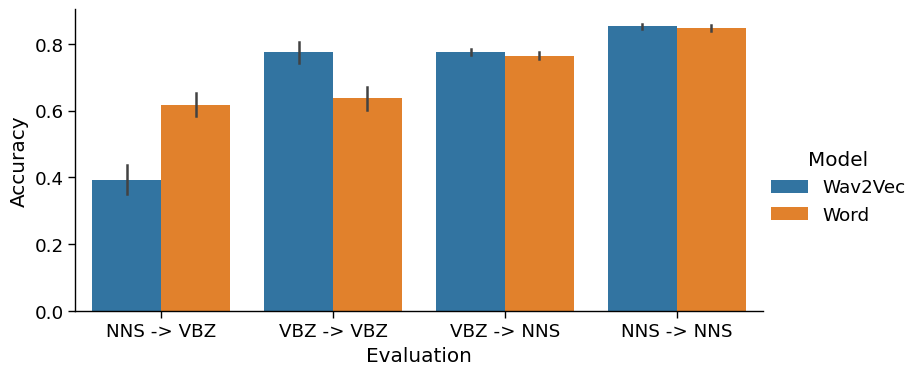

In [28]:
nnvb_plot = nnvb_focus.groupby(["model_label", "inflection_from", "inflection_to", "base_to"]).correct.mean().reset_index()
nnvb_plot["transfer_label"] = nnvb_plot.inflection_from + " -> " + nnvb_plot.inflection_to
order = nnvb_plot.groupby("transfer_label").correct.mean().sort_values().index
g = sns.catplot(data=nnvb_plot, x="transfer_label", y="correct", kind="bar", hue="model_label", order=order, errorbar="se", height=4, aspect=2)
g._legend.set_title("Model")
ax = g.axes.flat[0]

ax.set_xlabel("Evaluation")
ax.set_ylabel("Accuracy")

/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(55.33481032986113, 0.5, 'Accuracy')

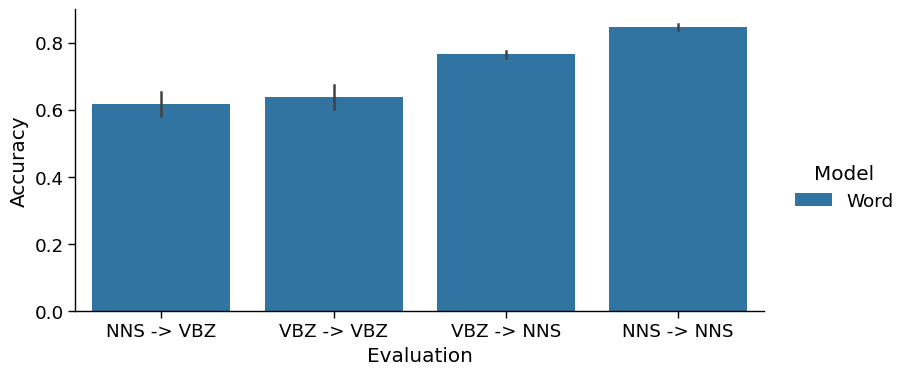

In [29]:
nnvb_plot = nnvb_focus.groupby(["model_label", "inflection_from", "inflection_to", "base_to"]).correct.mean().reset_index()
nnvb_plot["transfer_label"] = nnvb_plot.inflection_from + " -> " + nnvb_plot.inflection_to
order = nnvb_plot.groupby("transfer_label").correct.mean().sort_values().index
g = sns.catplot(data=nnvb_plot.query("model_label == 'Word'"), x="transfer_label", y="correct", kind="bar", hue="model_label", order=order, errorbar="se", height=4, aspect=2)
g._legend.set_title("Model")
ax = g.axes.flat[0]

ax.set_xlabel("Evaluation")
ax.set_ylabel("Accuracy")

/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(70.44940711805556, 0.5, 'Accuracy')

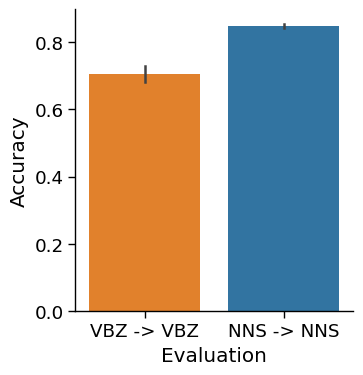

In [30]:
nnvb_phase1 = nnvb_plot[nnvb_plot.inflection_from == nnvb_plot.inflection_to]
order = nnvb_phase1.groupby("transfer_label").correct.mean().sort_values().index
g = sns.catplot(data=nnvb_phase1, x="transfer_label", y="correct", kind="bar", hue="inflection_to", order=order, errorbar="se", height=4, aspect=1)
# remove legend
g._legend.remove()
ax = g.axes.flat[0]

ax.set_xlabel("Evaluation")
ax.set_ylabel("Accuracy")

/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(56.51968379629632, 0.5, 'Mean accuracy')

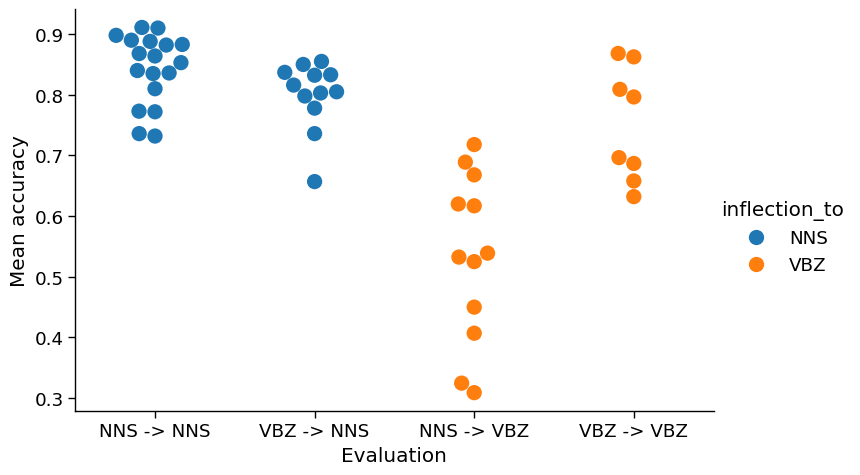

In [31]:
order = sorted(nnvb_results_summary.transfer_label.unique(), key=lambda x: x[4:])
g = sns.catplot(data=nnvb_results_summary, x="transfer_label", y="mean", hue="inflection_to",
            order=order, kind="swarm", errorbar="se", height=5, aspect=1.5, size=11)
ax = g.axes.flat[0]
ax.set_xlabel("Evaluation")
ax.set_ylabel("Mean accuracy")

### Regression analysis

In [43]:
# def get_interaction_strength(rows):
#     rows["correct"] = rows.correct.astype(int)
    
#     # exclude rare
#     rows = rows[~((rows.inflection_from == "VBZ") & rows.inflection_from == "IH Z") &
#                 ~((rows.inflection_to == "VBZ") & rows.inflection_to == "IH Z")]
    
#     # standardize frequency
#     rows["from_freq"] = (rows.from_freq - rows.from_freq.mean()) / rows.from_freq.std()
#     rows["to_freq"] = (rows.to_freq - rows.to_freq.mean()) / rows.to_freq.std()
    
#     formula = "correct ~ C(inflection_from, Treatment(reference='NNS')) * C(inflection_to, Treatment(reference='NNS')) + " \
#               "C(allomorph_from, Treatment(reference='Z')) * C(allomorph_to, Treatment(reference='Z')) +" \
#               "from_freq + to_freq"
    
#     model = logit(formula, data=rows).fit()

#     return model.params

In [44]:
# interaction_strengths = all_nnvb_results.groupby(run_groupers).apply(get_interaction_strength) \
#     .reset_index().melt(id_vars=run_groupers, value_name="coef_norm")
# interaction_strengths = interaction_strengths[interaction_strengths.variable.str.contains(":", regex=True)]
# interaction_strengths = interaction_strengths.groupby(run_groupers).coef_norm.apply(lambda xs: np.linalg.norm(xs, ord=1)).sort_values()

In [45]:
# plot_accuracy = all_nnvb_results.groupby(run_groupers).correct.mean().reindex(plot_runs).reset_index()
# plot_accuracy["layer"] = plot_accuracy.base_model_name.str.extract(r"_(\d+)$").astype(int)

# g = sns.catplot(data=plot_accuracy, x="layer", y="correct", hue="model_name", height=3, aspect=2, kind="point")
# # g.figure.tight_layout()
# g.figure.savefig(f"{output_dir}/nnvb_layer_wise.pdf")

In [46]:
# plot_is = interaction_strengths.reindex(plot_runs).reset_index()
# plot_is["layer"] = plot_is.base_model_name.str.extract(r"_(\d+)$").astype(int)

# g = sns.catplot(data=plot_is, x="layer", y="coef_norm", hue="model_name", kind="point", height=3, aspect=2)
# g.axes.flat[0].set_ylabel("Allomorph/inflection\ninteraction strength")
# g.axes.flat[0].set_xlabel("Layer")

# g.savefig(f"{output_dir}/interaction_strength.pdf")

### Digression

In [47]:
study_df = nnvb_focus[(nnvb_focus.inflection_to == "VBZ")].copy()

In [48]:
study_df["predicted_stem"] = study_df.predicted_label.str.replace(r"s$|ed$|ings?$", "", regex=True)
study_df["base_to_stem"] = study_df.base_to.str.replace(r"e$", "", regex=True).replace(r"y$", "i", regex=True)
study_df["predicted_within_inflection"] = \
    (study_df.predicted_stem == study_df.base_to) | (study_df.predicted_stem == study_df.base_to_stem)
vb_irregulars = [("do", "did"), ("do", "does"), ("begin", "began"), ("learn", "learnt"), ("send", "sent"), ("shine", "shone"), ("seem", "seem'd"), ("read", "red"),
                 ("possess", "possesses"), ("bring", "brings"), ("carry", "carries"), ("occur", "occurred"), ("think", "thinkest"), ("grow", "grew"),
                 ("put", "putting"), ("begin", "beginning"), ("give", "givest"),
                 # homophones
                 ("allow", "aloud"), ("write", "rights"), ("write", "wright's"), ("depend", "dependent")]
for base, predicted in vb_irregulars:
    study_df.loc[study_df.base_to == base, "predicted_within_inflection"] |= study_df.loc[study_df.base_to == base].predicted_label == predicted

In [49]:
# study_df[~study_df.predicted_within_inflection].groupby("base_to").predicted_label.value_counts().sort_values(ascending=False).iloc[60:80]

In [50]:
nnvb_focus

,equivalence,model_name,base_model_name,Unnamed: 1,group,from_equiv_label,to_equiv_label,base_from,base_to,inflection_from,...,inflected_to,from_base_freq,from_inflected_freq,to_base_freq,to_inflected_freq,from_freq,to_freq,to_freq_bin,from_freq_bin,model_label
experiment,,,,,,,,,,,,,,,,,,,,,
unambiguous-NNS_Z_to_NNS_Z,word_broad_10frames_fixedlen25,ff_32,w2v2_8,0,None,"('champion', 'champions')","('sister', 'sisters')",champion,sister,NNS,...,sisters,10.616698,10.312125,11.101817,10.575098,10.464411,10.838458,Q4,Q3,Word
unambiguous-NNS_Z_to_NNS_Z,word_broad_10frames_fixedlen25,ff_32,w2v2_8,1,None,"('vision', 'visions')","('year', 'years')",vision,year,NNS,...,years,10.714653,9.870331,12.146887,12.033642,10.292492,12.090264,Q5,Q3,Word
unambiguous-NNS_Z_to_NNS_Z,word_broad_10frames_fixedlen25,ff_32,w2v2_8,2,None,"('mosquito', 'mosquitoes')","('obstacle', 'obstacles')",mosquito,obstacle,NNS,...,obstacles,9.522033,9.423987,9.814660,9.998145,9.473010,9.906402,Q2,Q1,Word
unambiguous-NNS_Z_to_NNS_Z,word_broad_10frames_fixedlen25,ff_32,w2v2_8,3,None,"('individual', 'individuals')","('contemporary', 'contemporaries')",individual,contemporary,NNS,...,contemporaries,10.899842,10.676617,10.484602,9.302198,10.788230,9.893400,Q2,Q4,Word
unambiguous-NNS_Z_to_NNS_Z,word_broad_10frames_fixedlen25,ff_32,w2v2_8,4,None,"('grave', 'graves')","('energy', 'energies')",grave,energy,NNS,...,energies,10.178762,9.816200,11.227253,9.606977,9.997481,10.417115,Q3,Q2,Word
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
unambiguous-VBZ_IH Z_to_VBZ_IH Z,id,id,w2v2_8,7,None,"('possess', 'possesses')","('please', 'pleases')",possess,please,VBZ,...,pleases,9.916021,9.477451,11.690215,9.321830,9.696736,10.506022,Q3,Q1,Wav2Vec
unambiguous-VBZ_IH Z_to_VBZ_IH Z,id,id,w2v2_8,8,None,"('do', 'does')","('please', 'pleases')",do,please,VBZ,...,pleases,12.447336,11.782977,11.690215,9.321830,12.115157,10.506022,Q3,Q5,Wav2Vec
unambiguous-VBZ_IH Z_to_VBZ_IH Z,id,id,w2v2_8,9,None,"('please', 'pleases')","('do', 'does')",please,do,VBZ,...,does,11.690215,9.321830,12.447336,11.782977,10.506022,12.115157,Q5,Q3,Wav2Vec


In [51]:
merge_keys = ["experiment", "equivalence", "model_label", "model_name", "base_model_name", "group", "inflection_from", "inflection_to", "base_from", "inflected_from", "base_to", "inflected_to"]
nnvb_focus = pd.merge(nnvb_focus.reset_index(), study_df.reset_index()[merge_keys + ["predicted_within_inflection"]],
         on=merge_keys, how="left")

In [52]:
nnvb_focus["correct_or_predicted_within_inflection"] = nnvb_focus.correct | nnvb_focus.predicted_within_inflection

In [85]:
nnvb_results_summary2 = nnvb_focus.groupby(["model_label", "inflection_from", "inflection_to"]) \
    [["correct_or_predicted_within_inflection", "correct", "gt_label_rank", "gt_distance"]].mean().reset_index()

nnvb_results_summary2["transfer_label"] = nnvb_results_summary2.inflection_from + " -> " + nnvb_results_summary2.inflection_to
nnvb_results_summary2

,model_label,inflection_from,inflection_to,correct_or_predicted_within_inflection,correct,gt_label_rank,gt_distance,transfer_label
0,Wav2Vec,NNS,NNS,0.836111,0.836111,6.324000,0.833854,NNS -> NNS
1,Wav2Vec,NNS,VBZ,0.766207,0.356942,70.623022,0.816985,NNS -> VBZ
2,Wav2Vec,VBZ,NNS,0.768249,0.768249,24.803216,0.837957,VBZ -> NNS
3,Wav2Vec,VBZ,VBZ,0.914785,0.770940,36.068463,0.825766,VBZ -> VBZ
4,Word,NNS,NNS,0.850667,0.850667,0.694667,1.154509,NNS -> NNS
5,Word,NNS,VBZ,0.816360,0.615875,8.690020,1.061363,NNS -> VBZ
6,Word,VBZ,NNS,0.778203,0.778203,2.203931,1.151698,VBZ -> NNS
7,Word,VBZ,VBZ,0.871085,0.635834,5.902039,1.048129,VBZ -> VBZ


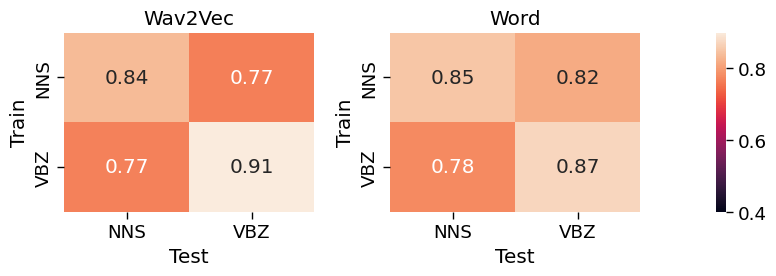

In [86]:
f, axs = plt.subplots(1, 3, figsize=(4 * 2, 3), gridspec_kw={'width_ratios': [1, 1, 0.04]})

for i, (ax, (model_label, rows)) in enumerate(zip(axs, nnvb_results_summary2.groupby("model_label"))):
    cbar_ax = None
    if i == 1:
        cbar_ax = axs.flat[-1]
    
    ax.set_title(model_label)
    sns.heatmap(rows.set_index(["inflection_from", "inflection_to"]).correct_or_predicted_within_inflection.unstack(),
                vmin=main_plot_vmin, vmax=main_plot_vmax,
                annot=True, ax=ax, cbar=i == 1, cbar_ax=cbar_ax)
    ax.set_xlabel("Test")
    ax.set_ylabel("Train")

f = plt.gcf()
f.tight_layout()
f.savefig(f"{output_dir}/nnvb_results-correct_inflection.pdf")

/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(57.98174218750002, 0.5, 'Accuracy')

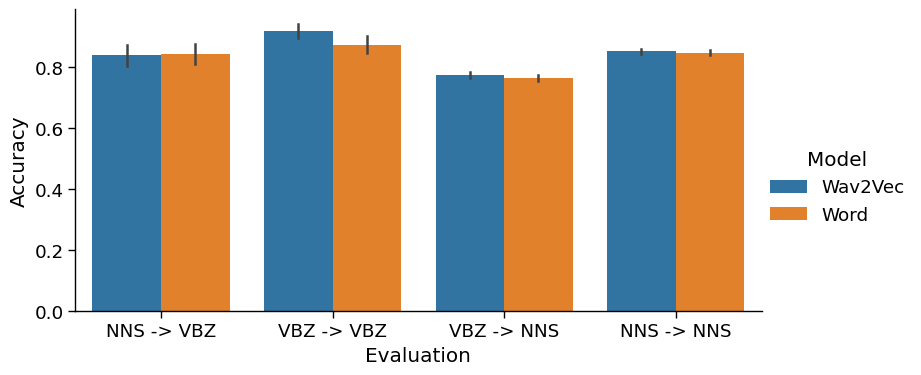

In [87]:
nnvb_plot = nnvb_focus.groupby(["model_label", "inflection_from", "inflection_to", "base_to"]).correct_or_predicted_within_inflection.mean().reset_index()
nnvb_plot["transfer_label"] = nnvb_plot.inflection_from + " -> " + nnvb_plot.inflection_to
order = ["NNS -> VBZ", "VBZ -> VBZ", "VBZ -> NNS", "NNS -> NNS"]
g = sns.catplot(data=nnvb_plot, x="transfer_label", y="correct_or_predicted_within_inflection", kind="bar", hue="model_label", order=order, errorbar="se", height=4, aspect=2)
g._legend.set_title("Model")
ax = g.axes.flat[0]

ax.set_xlabel("Evaluation")
ax.set_ylabel("Accuracy")

### Frequency analysis

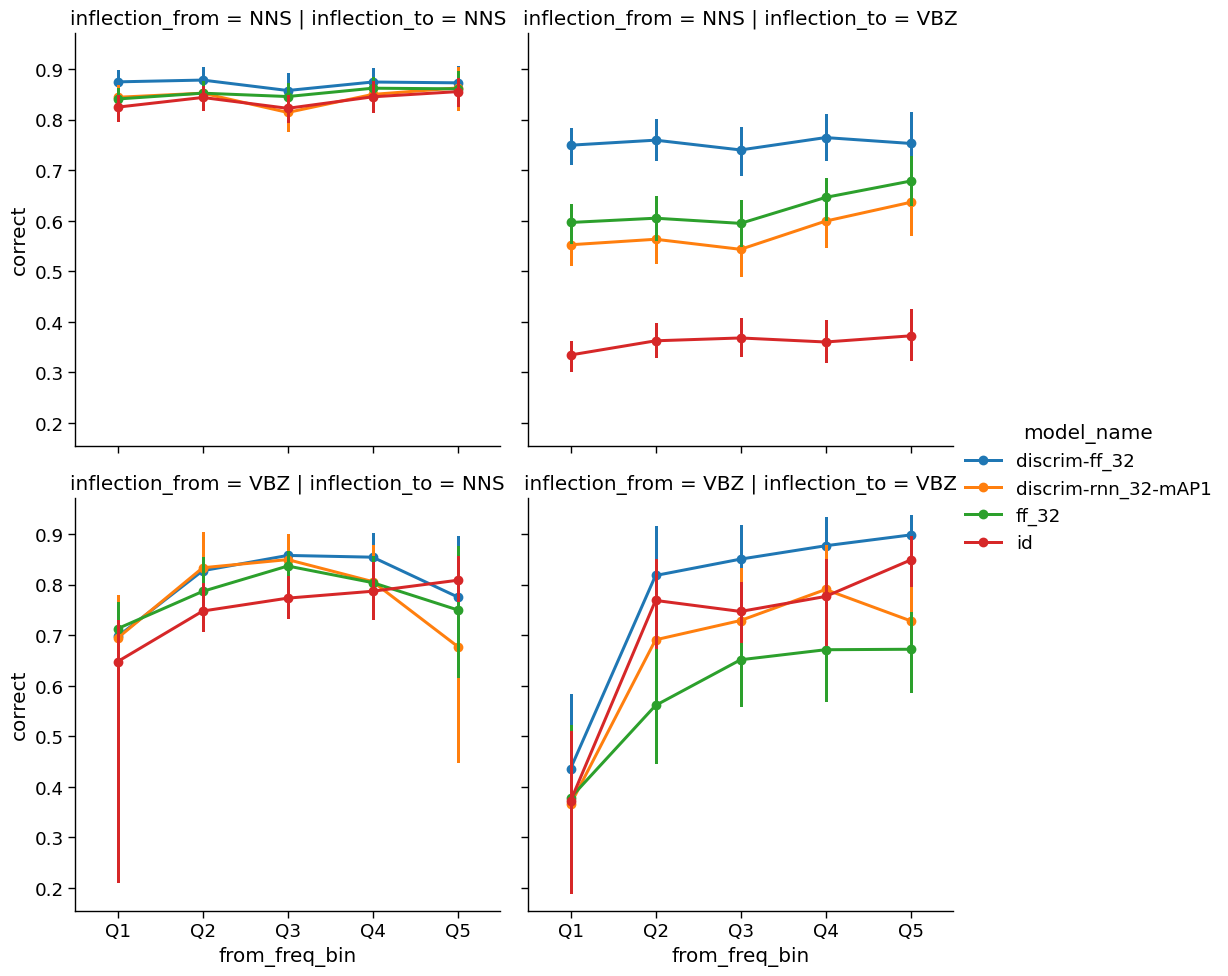

In [88]:
sns.catplot(data=all_nnvb_results.query("base_model_name == 'w2v2_8'").reset_index(),
            x="from_freq_bin", y="correct", hue="model_name",
            row="inflection_from", col="inflection_to", units="base_from", kind="point")

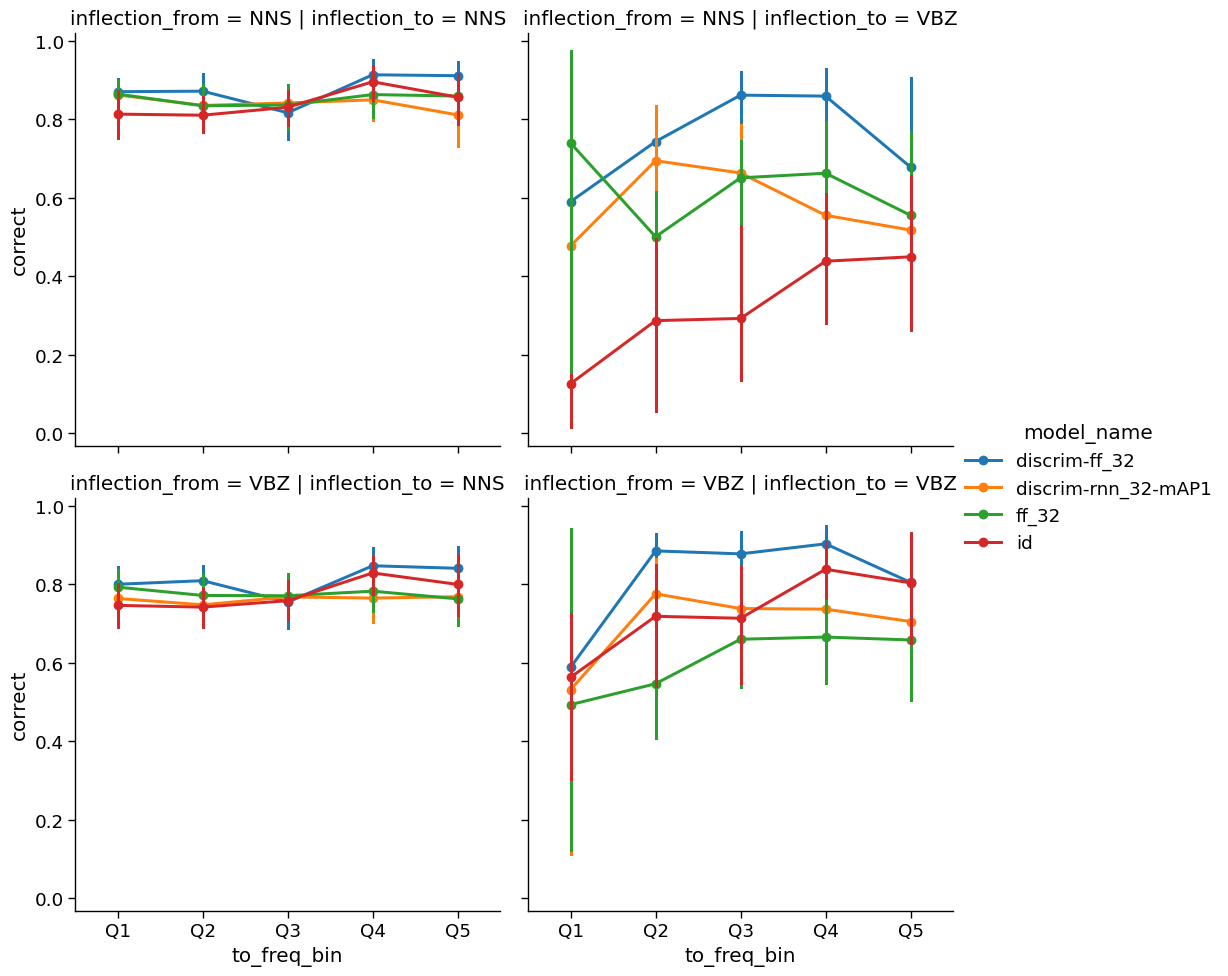

In [89]:
sns.catplot(data=all_nnvb_results.query("base_model_name == 'w2v2_8'").reset_index(),
            x="to_freq_bin", y="correct", hue="model_name",
            row="inflection_from", col="inflection_to", units="base_to", kind="point")

## False friend analysis

In [90]:
all_ff_results = []

for run, run_results in all_results.groupby(run_groupers):
    run_results = run_results.set_index("experiment")
    false_friend_expts = run_results.index.unique()
    false_friend_expts = false_friend_expts[false_friend_expts.str.contains("FF")]

    for expt_name in false_friend_expts:
        expt_df = run_results.loc[expt_name].copy()
        num_seen_words = min(len(expt_df.base_from.unique()), len(expt_df.base_to.unique()))

        if num_seen_words < 10:
            print(f"Skipping {expt} due to only {num_seen_words} seen words")
            continue

        if expt_name.count("-FF-") == 2:
            allomorph_from, allomorph_to = re.findall(r"-FF-([\w\s]+)-to-.+FF-([\w\s]+)", expt_name)[0]
            ff_from, ff_to = True, True
        else:
            try:
                allomorph_from, allomorph_to = re.findall(r"_([\w\s]+)-to-.+FF-([\w\s]+)", expt_name)[0]
                # is the false friend on the "from" side?
                ff_from, ff_to = False, True
            except:
                allomorph_from, allomorph_to = re.findall(r".+FF-([\w\s]+)-to-.+_([\w\s]+)", expt_name)[0]
                ff_from, ff_to = True, False

        expt_df["allomorph_from"] = allomorph_from
        expt_df["allomorph_to"] = allomorph_to

        if ff_from:
            expt_df["inflection_from"] = expt_df.inflection_from.str.replace("-FF-.+", "-FF", regex=True)
        if ff_to:
            expt_df["inflection_to"] = expt_df.inflection_to.str.replace("-FF-.+", "-FF", regex=True)

        expt_df["ff_from"] = ff_from
        expt_df["ff_to"] = ff_to

        all_ff_results.append(expt_df)

    # add within-false-friend tests
    expt_df = run_results.loc["false_friends"].copy()
    expt_df["allomorph_from"] = expt_df.inflection_from.str.extract(r"FF-(.+)$")
    expt_df["allomorph_to"] = expt_df.inflection_to.str.extract(r"FF-(.+)$")
    expt_df["inflection_from"] = expt_df.inflection_from.str.replace("-FF-.+", "-FF", regex=True)
    expt_df["inflection_to"] = expt_df.inflection_to.str.replace("-FF-.+", "-FF", regex=True)
    expt_df["ff_from"] = True
    expt_df["ff_to"] = True

    all_ff_results.append(expt_df)

    # expt_df = expt_df[expt_df.inflection_from.isin(all_ff_results.inflection_from.unique())]

all_ff_results = pd.concat(all_ff_results).reset_index()

ff_exclude = "wreck e eh wandering lo chiu ha hahn meek jew"
ff_exclude_inflected = "bunce los"

# exclude FF bases
all_ff_results = all_ff_results[~(all_ff_results.inflection_from.str.endswith("-FF") & all_ff_results.base_from.isin(ff_exclude.split()))]
all_ff_results = all_ff_results[~(all_ff_results.inflection_to.str.endswith("-FF") & all_ff_results.base_to.isin(ff_exclude.split()))]

all_ff_results["inflected_from"] = all_ff_results.from_equiv_label.apply(lambda x: eval(x)[1])
all_ff_results["inflected_to"] = all_ff_results.to_equiv_label.apply(lambda x: eval(x)[1])

# exclude FF inflected
all_ff_results = all_ff_results[~(all_ff_results.inflection_from.str.endswith("-FF") & all_ff_results.inflected_from.isin(ff_exclude_inflected.split()))]
all_ff_results = all_ff_results[~(all_ff_results.inflection_to.str.endswith("-FF") & all_ff_results.inflected_to.isin(ff_exclude_inflected.split()))]

# add frequency information
all_ff_results = pd.merge(all_ff_results, word_freq_df["LogFreq"].rename("from_base_freq"), left_on="base_from", right_index=True)
all_ff_results = pd.merge(all_ff_results, word_freq_df["LogFreq"].rename("to_base_freq"), left_on="base_to", right_index=True)
all_ff_results = pd.merge(all_ff_results, word_freq_df["LogFreq"].rename("from_inflected_freq"), left_on="inflected_from", right_index=True)
all_ff_results = pd.merge(all_ff_results, word_freq_df["LogFreq"].rename("to_inflected_freq"), left_on="inflected_to", right_index=True)
all_ff_results["from_freq"] = all_ff_results[["from_base_freq", "from_inflected_freq"]].mean(axis=1)
all_ff_results["to_freq"] = all_ff_results[["to_base_freq", "to_inflected_freq"]].mean(axis=1)

all_ff_results["transfer_label"] = all_ff_results.inflection_from + " -> " + all_ff_results.inflection_to

Skipping unambiguous-VBZ_IH Z_to_VBZ_IH Z due to only 1 seen words
Skipping unambiguous-VBZ_IH Z_to_VBZ_IH Z due to only 1 seen words
Skipping unambiguous-VBZ_IH Z_to_VBZ_IH Z due to only 1 seen words
Skipping unambiguous-VBZ_IH Z_to_VBZ_IH Z due to only 1 seen words
Skipping unambiguous-VBZ_IH Z_to_VBZ_IH Z due to only 1 seen words
Skipping unambiguous-VBZ_IH Z_to_VBZ_IH Z due to only 1 seen words
Skipping unambiguous-VBZ_IH Z_to_VBZ_IH Z due to only 1 seen words
Skipping unambiguous-VBZ_IH Z_to_VBZ_IH Z due to only 1 seen words
Skipping unambiguous-VBZ_IH Z_to_VBZ_IH Z due to only 1 seen words
Skipping unambiguous-VBZ_IH Z_to_VBZ_IH Z due to only 1 seen words
Skipping unambiguous-VBZ_IH Z_to_VBZ_IH Z due to only 1 seen words
Skipping unambiguous-VBZ_IH Z_to_VBZ_IH Z due to only 1 seen words
Skipping unambiguous-VBZ_IH Z_to_VBZ_IH Z due to only 4 seen words
Skipping unambiguous-VBZ_IH Z_to_VBZ_IH Z due to only 4 seen words
Skipping unambiguous-VBZ_IH Z_to_VBZ_IH Z due to only 4 seen w

In [91]:
# Post-hoc fix some bugs
all_ff_results.loc[(all_ff_results.base_to == "tho") & (all_ff_results.predicted_label == "though") & (all_ff_results.gt_label_rank == 1), "correct"] = True
all_ff_results.loc[(all_ff_results.base_to == "philip") & (all_ff_results.predicted_label == "philip's"), "correct"] = True
all_ff_results.loc[(all_ff_results.base_to == "adam") & (all_ff_results.predicted_label == "adam's"), "correct"] = True
all_ff_results.loc[(all_ff_results.base_to == "who") & (all_ff_results.predicted_label == "who's"), "correct"] = True

In [92]:
false_friend_strong_lookup = false_friends_df.set_index(["base", "inflected", "post_divergence"]).strong.to_dict()

In [93]:
def get_is_strong(rows):
    keys = []
    row = rows.iloc[0]
    if "-FF" in row.inflection_from:
        keys.append((row.base_from, row.inflected_from, row.allomorph_from))
    if "-FF" in row.inflection_to:
        keys.append((row.base_to, row.inflected_to, row.allomorph_to))

    # print(keys)
    strong_results = [false_friend_strong_lookup[base, inflected, allomorph] for base, inflected, allomorph in keys]
    return all(strong_results)

strong_grouper = ["inflection_from", "inflection_to", "inflected_from", "inflected_to", "base_from", "base_to", "allomorph_from", "allomorph_to"]
strong_values = all_ff_results.groupby(strong_grouper).apply(get_is_strong).rename("is_strong")
all_ff_results = pd.merge(all_ff_results, strong_values, left_on=strong_grouper, right_index=True)

/tmp/ipykernel_3569269/500092804.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  strong_values = all_ff_results.groupby(strong_grouper).apply(get_is_strong).rename("is_strong")


In [94]:
weak_ff_results = all_ff_results[~all_ff_results.is_strong]

# ONLY STRONG
all_ff_results = all_ff_results[all_ff_results.is_strong]

### Weak sub-analysis

In [95]:
ss = StateSpaceAnalysisSpec.from_hdf5(state_space_path)

/scratch/jgauthier/transformers/lib/python3.10/site-packages/tables/attributeset.py:295: DataTypeWarning: Unsupported type for attribute 'labels_are_repr' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


In [96]:
# these base forms participate in a real inflection,
# so they have a distractor
weak_alternates = {
    "barbara": "barbara's",
    "bay": "bays",
    "den": "dens",
    "dew": "dews",
    "fall": "falls",
    "fear": "fears",
    "flee": "flees",
    "hen": "hens",
    "her": "hers",
    "jew": "jews",
    "joy": "joys",
    "lay": "lays",
    "one": "ones one's",
    "patricia": "patricia's",
    "peer": "peers",
    "per": "purrs",
    "river": "rivers river's",
    "saw": "saws",
    "scare": "scares",
    "sin": "sins",
    "syria": "syria's",
    "victoria": "victoria's"
}

# Only retain cases where the alternate is in the vocabulary
drop_cases = [k for k, v in weak_alternates.items() if not any(word in ss.labels for word in v.split(" "))]
print(f"Dropping {len(drop_cases)} cases: {drop_cases}")
weak_alternates = {k: v for k, v in weak_alternates.items() if any(word in ss.labels for word in v.split(" "))}

Dropping 5 cases: ['barbara', 'per', 'scare', 'syria', 'victoria']


In [97]:
weak_ff_results[~weak_ff_results.base_to.map(weak_alternates).isnull() & weak_ff_results.ff_to].base_to.unique()

array(['one', 'joy', 'flee', 'hen', 'dew', 'saw', 'her', 'fall', 'lay',
       'den', 'fear', 'sin', 'peer', 'patricia', 'bay', 'river'],
      dtype=object)

In [98]:
weak_ff_results[weak_ff_results.base_to.map(weak_alternates).isnull() & weak_ff_results.ff_to].base_to.unique()

array(['really', 'robert', 'syria', 'scare', 'barbara', 'then', 'when',
       'julia', 'dan', 'far', 'ran', 'militia', 'victoria', 'per',
       'philip', 'sick', 'quit', 'stoop', 'll', 'live', 'ridge', 'rap',
       'flew', 'an', 'way', 'complain', 'knee', 'spy', 'der', 'why',
       'robber', 'bough', 'off', 'on', 'b', 'shore', 'worse', 'drew',
       'join', 'fry', 'day', 'sly', 'fee', 'stray', 'ferris', 'to',
       'ardan', 'law', 'ten', 'humorous', 'shall', 'less', 'go', 'thro',
       'fray', 'patten', 'we', 'gone', 'co', 'tray', 'gray', 'pa', 'gay',
       'mass', 'des', 'pine', 'tie', 'are', 'safer', 'k', 'for', 'pursue',
       'me', 'slay', 'rue', 'play', 'ray', 'ye', 'hearse', 'sane', 'gill',
       'restrain', 'she', 'car', 'wren', 'tin', 'fly', 'inner', 'gnaw',
       'la', 'hard', 'can', 'stir', 'tramp', 'deaf', 'pie', 'yer', 'dark',
       'light', 'lie'], dtype=object)

In [99]:
weak_sub_df = weak_ff_results[weak_ff_results.ff_to].copy()
weak_sub_df["competitor_to"] = weak_sub_df.base_to.map(weak_alternates)
weak_sub_df = weak_sub_df[weak_sub_df.competitor_to.notnull()]
weak_sub_df = weak_sub_df.query("base_model_name == @focus_base_model and model_name == @focus_model and equivalence == @focus_equivalence")
weak_sub_df["alternate_match"] = weak_sub_df.apply(lambda xs: re.match(f"\\b{xs.predicted_label}\\b", xs.competitor_to) is not None, axis=1)
weak_sub_df["source_label"] = weak_sub_df.inflection_from + " " + weak_sub_df.allomorph_from
# just study /S/ false friends right now
weak_sub_df = weak_sub_df.query("inflection_to in ['VBZ-FF', 'NNS-FF'] and allomorph_to == 'S' and allomorph_from in ['Z', 'S']")
weak_sub_df

,experiment,equivalence,model_name,base_model_name,Unnamed: 1,group,from_equiv_label,to_equiv_label,base_from,base_to,...,to_base_freq,from_inflected_freq,to_inflected_freq,from_freq,to_freq,transfer_label,is_strong,competitor_to,alternate_match,source_label
806506,NNS_Z-to-NNS-FF-S,word_broad_10frames_fixedlen25,ff_32,w2v2_8,2,None,"('noble', 'nobles')","('one', 'once')",noble,one,...,12.531016,9.055378,11.631848,9.648388,12.081432,NNS -> NNS-FF,False,ones one's,False,NNS Z
806508,NNS_Z-to-NNS-FF-S,word_broad_10frames_fixedlen25,ff_32,w2v2_8,4,None,"('example', 'examples')","('one', 'once')",example,one,...,12.531016,10.464344,11.631848,10.805515,12.081432,NNS -> NNS-FF,False,ones one's,False,NNS Z
806510,NNS_Z-to-NNS-FF-S,word_broad_10frames_fixedlen25,ff_32,w2v2_8,6,None,"('thing', 'things')","('joy', 'joyce')",thing,joy,...,10.870060,11.935970,10.007646,11.875488,10.438853,NNS -> NNS-FF,False,joys,True,NNS Z
806515,NNS_Z-to-NNS-FF-S,word_broad_10frames_fixedlen25,ff_32,w2v2_8,11,None,"('intention', 'intentions')","('flee', 'fleece')",intention,flee,...,9.762252,10.117998,9.458603,10.168287,9.610428,NNS -> NNS-FF,False,flees,True,NNS Z
806516,NNS_Z-to-NNS-FF-S,word_broad_10frames_fixedlen25,ff_32,w2v2_8,12,None,"('official', 'officials')","('hen', 'hence')",official,hen,...,9.567942,11.318022,10.264728,11.165465,9.916335,NNS -> NNS-FF,False,hens,False,NNS Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
830064,false_friends,word_broad_10frames_fixedlen25,ff_32,w2v2_8,4712,"(VBZ-FF-S,)","('dan', 'dance', 'S')","('river', 'reverse', 'S')",dan,river,...,11.056219,11.126207,10.229693,10.914424,10.642956,VBZ-FF -> VBZ-FF,False,rivers river's,False,VBZ-FF S
830070,false_friends,word_broad_10frames_fixedlen25,ff_32,w2v2_8,4718,"(VBZ-FF-S,)","('hen', 'hence', 'S')","('bay', 'base', 'S')",hen,bay,...,10.974028,10.264728,10.996625,9.916335,10.985327,VBZ-FF -> VBZ-FF,False,bays,False,VBZ-FF S
830072,false_friends,word_broad_10frames_fixedlen25,ff_32,w2v2_8,4720,"(VBZ-FF-S,)","('her', 'hearse', 'S')","('one', 'once', 'S')",her,one,...,12.531016,8.983230,11.631848,10.683965,12.081432,VBZ-FF -> VBZ-FF,False,ones one's,True,VBZ-FF S
830073,false_friends,word_broad_10frames_fixedlen25,ff_32,w2v2_8,4721,"(VBZ-FF-S,)","('one', 'once', 'S')","('sin', 'since', 'S')",one,sin,...,10.445628,11.631848,11.838362,12.081432,11.141995,VBZ-FF -> VBZ-FF,False,sins,True,VBZ-FF S


In [100]:
def get_props(xs):
    return pd.Series({
        "correct": xs.correct.sum(),
        "alternate_match": xs.alternate_match.sum(),
        "prop_correct": xs.correct.sum() / len(xs),#(xs.correct.sum() + xs.alternate_match.sum()),
        "prop_alternate_match": xs.alternate_match.sum() / len(xs),#/ (xs.correct.sum() + xs.alternate_match.sum())
    })
weak_sub_plot = weak_sub_df.groupby(["source_label", "inflection_to", "base_to"]).apply(get_props).reset_index()
weak_sub_plot["source_label"] = weak_sub_plot.source_label.str.replace(r"(NNS|VBZ)-?\s*", "", regex=True)

/tmp/ipykernel_3569269/1070867578.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weak_sub_plot = weak_sub_df.groupby(["source_label", "inflection_to", "base_to"]).apply(get_props).reset_index()


/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/jgauthier/

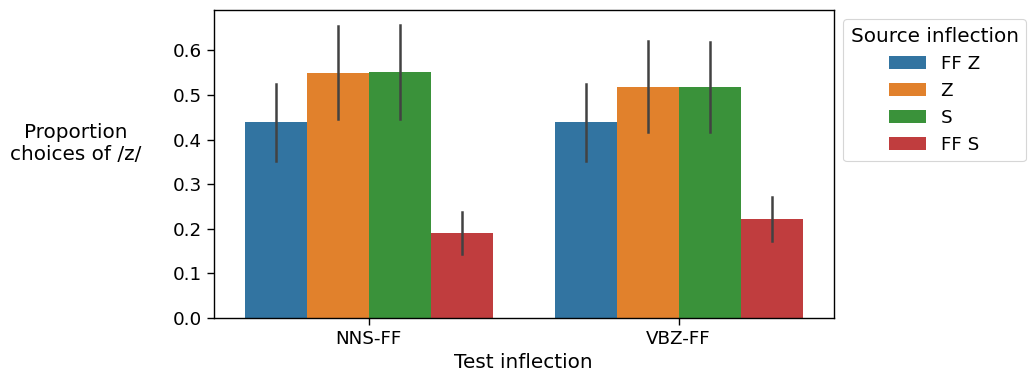

In [101]:
from matplotlib.patches import bbox_artist

f, ax = plt.subplots(figsize=(8, 4))

hue_order = weak_sub_plot.groupby("source_label").prop_correct.mean().sort_values().index
ax = sns.barplot(data=weak_sub_plot, x="inflection_to", hue="source_label", hue_order=hue_order, y="prop_alternate_match", errorbar="se")
ax.set_ylabel("Proportion\nchoices of /z/", rotation=0, labelpad=70)
ax.set_xlabel("Test inflection")
ax.legend(title="Source inflection", loc="upper right", bbox_to_anchor=(1.325, 1))
# ax.figure.tight_layout()

/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/jgauthier/

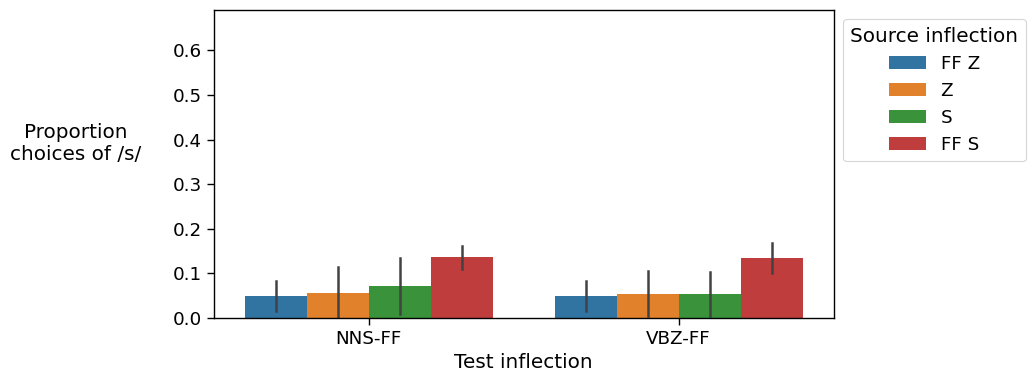

In [102]:
from matplotlib.patches import bbox_artist

f, ax2 = plt.subplots(figsize=(8, 4))

hue_order = weak_sub_plot.groupby("source_label").prop_correct.mean().sort_values().index
ax2 = sns.barplot(data=weak_sub_plot, x="inflection_to", hue="source_label", hue_order=hue_order, y="prop_correct", errorbar="se")
ax2.set_ylabel("Proportion\nchoices of /s/", rotation=0, labelpad=70)
ax2.set_xlabel("Test inflection")
ax2.set_ylim(ax.get_ylim())
ax2.legend(title="Source inflection", loc="upper right", bbox_to_anchor=(1.325, 1))
# ax.figure.tight_layout()

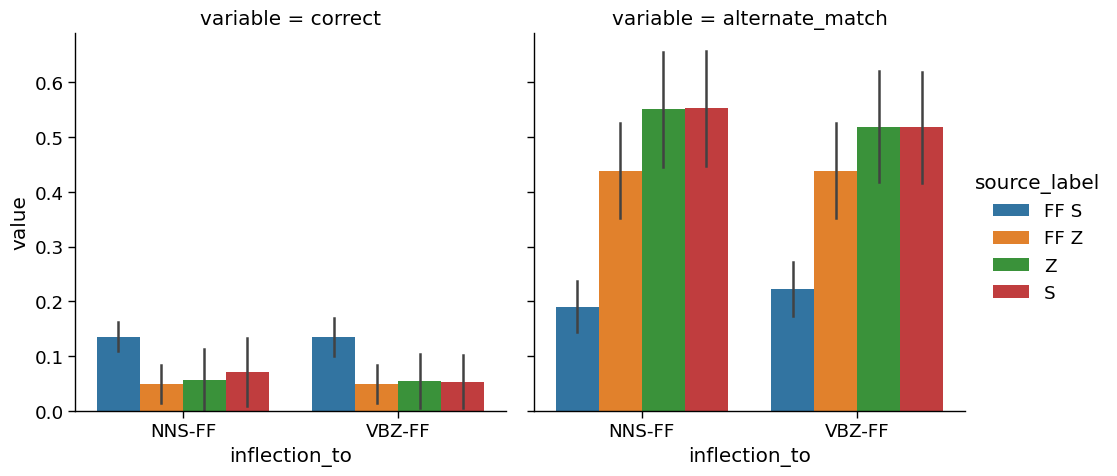

In [103]:
weak_sub_plot = weak_sub_df.groupby(["source_label", "inflection_to", "base_to"])[["correct", "alternate_match"]].mean().reset_index() \
    .melt(id_vars=["source_label", "inflection_to", "base_to"])
weak_sub_plot["source_label"] = weak_sub_plot.source_label.str.replace(r"(NNS|VBZ)-?\s*", "", regex=True)

hue_order = weak_sub_plot.groupby("source_label").value.mean().sort_values().index
sns.catplot(data=weak_sub_plot, x="inflection_to", hue="source_label", y="value", col="variable",
            hue_order=hue_order, kind="bar", errorbar="se")

In [104]:
weak_sub_df.groupby(["inflection_to", "source_label"]).correct.mean().groupby("inflection_to").apply(lambda xs: xs.sort_values())

inflection_to  inflection_to  source_label
NNS-FF         NNS-FF         NNS Z           0.048718
                              NNS-FF Z        0.049296
                              NNS S           0.079787
                              NNS-FF S        0.136943
VBZ-FF         VBZ-FF         VBZ Z           0.045455
                              VBZ-FF Z        0.049296
                              VBZ S           0.053571
                              VBZ-FF S        0.127796
Name: correct, dtype: float64

In [105]:
weak_sub_df.groupby(["inflection_to", "source_label"]).alternate_match.mean().groupby("inflection_to").apply(lambda xs: xs.sort_values())

inflection_to  inflection_to  source_label
NNS-FF         NNS-FF         NNS-FF S        0.191083
                              NNS-FF Z        0.440141
                              NNS S           0.558511
                              NNS Z           0.582051
VBZ-FF         VBZ-FF         VBZ-FF S        0.233227
                              VBZ-FF Z        0.440141
                              VBZ S           0.517857
                              VBZ Z           0.527778
Name: alternate_match, dtype: float64

We first consider the case of strong false friends, which have a concatenated /z/ /s/ or /Iz/ and could have been distributed by the same surface alternate pattern.
For example, "beside" -- "besides" does not instantiate the relevant morphological pattern, but the concatenation of /z/ is consistent with the pattern on the surface.
We see roughly similar results for strong false friends as for real morphological pairs.
This indicates that the surface alternation pattern extends beyond real morphological patterns; the representation is thus capturing something not at the morphological level here, but at the surface-alternate level.

We next consider the case of weak false friends, which have a concatenated /z/ /s/ or /Iz/ but do not respect the surface alternate pattern.
For example, "flee" -- "fleece" has the right concatenative relationship but does not respect the pattern (here we would expect to see /z/ following the vowel).
Generalization here is quite poor, indicating that the model is not appropriately applying the surface alternate pattern.
Error analysis reveals that the model is respecting the surface alternate pattern just as we expect.

We zoom in on weak false friends with concatenated /s/, for example "flee" "fleece." Here there is a competitor "flees" which respects the surface alternation pattern.
Call these items "weak false friends with alternates" (WFFA).
We evaluate the model's performance on WFFA from two sources: valid instances of plurals with /z/, and valid instances of plurals with /s/.
Computing analogies from the former category leads the model to predict the alternate form /z/, unsurprisingly.
However, computing analogies from the latter category leads the model to predict the alternate form /z/ at roughly the same rate!
This indicates that the latter category is not generating a context-free phonological representation, but rather a more abstract representation of "give me the right kind of surface alternate."

In [106]:
weak_sub2_df = weak_ff_results[weak_ff_results.ff_to].copy()
weak_sub2_df["competitor_to"] = weak_sub2_df.base_to.map(weak_alternates)
weak_sub2_df = weak_sub2_df[weak_sub2_df.competitor_to.isnull()]
weak_sub2_df = weak_sub2_df.query("base_model_name == @focus_base_model and model_name == @focus_model and equivalence == @focus_equivalence")
weak_sub2_df["source_label"] = weak_sub2_df.inflection_from + " " + weak_sub2_df.allomorph_from
# just study /S/ false friends right now
weak_sub2_df = weak_sub2_df.query("inflection_to in ['VBZ-FF', 'NNS-FF'] and allomorph_to == 'S' and allomorph_from in ['Z', 'S']")
weak_sub2_df

,experiment,equivalence,model_name,base_model_name,Unnamed: 1,group,from_equiv_label,to_equiv_label,base_from,base_to,...,from_base_freq,to_base_freq,from_inflected_freq,to_inflected_freq,from_freq,to_freq,transfer_label,is_strong,competitor_to,source_label
806504,NNS_Z-to-NNS-FF-S,word_broad_10frames_fixedlen25,ff_32,w2v2_8,0,None,"('crime', 'crimes')","('really', 'release')",crime,really,...,10.900412,12.122938,10.478456,11.098900,10.689434,11.610919,NNS -> NNS-FF,False,NaN,NNS Z
806507,NNS_Z-to-NNS-FF-S,word_broad_10frames_fixedlen25,ff_32,w2v2_8,3,None,"('meadow', 'meadows')","('robert', 'roberts')",meadow,robert,...,9.648483,10.943075,9.714459,10.299932,9.681471,10.621504,NNS -> NNS-FF,False,NaN,NNS Z
806509,NNS_Z-to-NNS-FF-S,word_broad_10frames_fixedlen25,ff_32,w2v2_8,5,None,"('meadow', 'meadows')","('syria', 'serious')",meadow,syria,...,9.648483,10.091909,9.714459,11.101976,9.681471,10.596942,NNS -> NNS-FF,False,NaN,NNS Z
806514,NNS_Z-to-NNS-FF-S,word_broad_10frames_fixedlen25,ff_32,w2v2_8,10,None,"('channel', 'channels')","('scare', 'scarce')",channel,scare,...,10.725112,10.140063,10.119147,9.626444,10.422130,9.883254,NNS -> NNS-FF,False,NaN,NNS Z
806520,NNS_Z-to-NNS-FF-S,word_broad_10frames_fixedlen25,ff_32,w2v2_8,16,None,"('drawer', 'drawers')","('barbara', 'barbarous')",drawer,barbara,...,9.911107,10.322070,9.674812,8.386371,9.792959,9.354220,NNS -> NNS-FF,False,NaN,NNS Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
830061,false_friends,word_broad_10frames_fixedlen25,ff_32,w2v2_8,4709,"(VBZ-FF-S,)","('sick', 'six', 'S')","('syria', 'serious', 'S')",sick,syria,...,11.086951,10.091909,11.332542,11.101976,11.209747,10.596942,VBZ-FF -> VBZ-FF,False,NaN,VBZ-FF S
830065,false_friends,word_broad_10frames_fixedlen25,ff_32,w2v2_8,4713,"(VBZ-FF-S,)","('far', 'farce', 'S')","('militia', 'malicious', 'S')",far,militia,...,11.599433,9.367348,9.289461,9.440728,10.444447,9.404038,VBZ-FF -> VBZ-FF,False,NaN,VBZ-FF S
830067,false_friends,word_broad_10frames_fixedlen25,ff_32,w2v2_8,4715,"(VBZ-FF-S,)","('robert', 'roberts', 'S')","('dan', 'dance', 'S')",robert,dan,...,10.943075,10.702641,10.299932,11.126207,10.621504,10.914424,VBZ-FF -> VBZ-FF,False,NaN,VBZ-FF S
830069,false_friends,word_broad_10frames_fixedlen25,ff_32,w2v2_8,4717,"(VBZ-FF-S,)","('then', 'thence', 'S')","('scare', 'scarce', 'S')",then,scare,...,12.157391,10.140063,8.763121,9.626444,10.460256,9.883254,VBZ-FF -> VBZ-FF,False,NaN,VBZ-FF S


In [107]:
weak_sub2_df.groupby(["inflection_to", "source_label"]).correct.mean().groupby("inflection_to").apply(lambda xs: xs.sort_values())

inflection_to  inflection_to  source_label
NNS-FF         NNS-FF         NNS-FF Z        0.257143
                              NNS Z           0.260997
                              NNS S           0.331250
                              NNS-FF S        0.335505
VBZ-FF         VBZ-FF         VBZ-FF Z        0.257143
                              VBZ Z           0.332378
                              VBZ S           0.352041
                              VBZ-FF S        0.369281
Name: correct, dtype: float64

### Main FF analysis

In [108]:
ff_frequency_bins = pd.qcut(pd.concat([all_ff_results.to_freq, all_ff_results.from_freq]), q=3, retbins=True)[1]
all_ff_results["from_freq_bin"] = pd.cut(all_ff_results.from_freq, bins=ff_frequency_bins, labels=[f"Q{i}" for i in range(1, 4)])
all_ff_results["to_freq_bin"] = pd.cut(all_ff_results.to_freq, bins=ff_frequency_bins, labels=[f"Q{i}" for i in range(1, 4)])

In [109]:
# Compare distribution of false friend word frequencies to distribution of NN/VB frequencies.
# This is to see if the false friends are more likely to be rare words.
false_friend_words = pd.concat([all_ff_results.query("ff_from").base_from, all_ff_results.query("ff_to").base_to]).unique()
nn_words = pd.concat([all_nnvb_results.query("inflection_from == 'NNS'").base_from,
                        all_nnvb_results.query("inflection_to == 'NNS'").base_to]).unique()
vb_words = pd.concat([all_nnvb_results.query("inflection_from == 'VBZ'").base_from,
                        all_nnvb_results.query("inflection_to == 'VBZ'").base_to]).unique()

In [110]:
expt_word_freqs = pd.concat({
    "false_friends": word_freq_df.loc[false_friend_words].LogFreq,
    "NN": word_freq_df.loc[nn_words].LogFreq,
    "VB": word_freq_df.loc[vb_words].LogFreq
}, names=["type"])

/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/jgauthier/

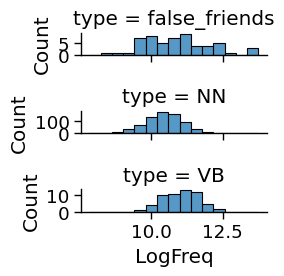

In [111]:
sns.displot(data=expt_word_freqs.reset_index(), x="LogFreq", row="type", kind="hist", bins=15,
            height=1, aspect=3, facet_kws={"sharey": False})

In [112]:
ff_results_summary2

,inflection_from,inflection_to,correct,gt_label_rank,gt_distance,transfer_label,model_label,correct_or_predicted_within_inflection,base_inflection
0,NNS,NNS-FF,0.690682,18.858067,1.045217,NNS -> NNS-FF,NaN,NaN,NNS
1,NNS-FF,NNS,0.744810,2.006920,1.166938,NNS-FF -> NNS,NaN,NaN,NNS
2,NNS-FF,NNS-FF,0.604106,31.794721,1.067607,NNS-FF -> NNS-FF,NaN,NaN,NNS
4,VBZ,VBZ-FF,0.692234,19.485139,1.062829,VBZ -> VBZ-FF,NaN,NaN,VBZ
5,VBZ-FF,VBZ,0.541468,10.149666,1.038552,VBZ-FF -> VBZ,NaN,NaN,VBZ
6,VBZ-FF,VBZ-FF,0.602339,30.356725,1.070823,VBZ-FF -> VBZ-FF,NaN,NaN,VBZ
4,NNS,NNS,NaN,0.694667,1.154509,NNS -> NNS,Word,0.850667,NNS
7,VBZ,VBZ,NaN,5.902039,1.048129,VBZ -> VBZ,Word,0.871085,VBZ


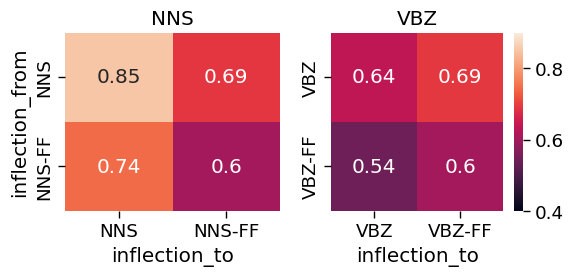

In [113]:
focus_ff_results = all_ff_results.query("base_model_name == @focus_base_model and model_name == @focus_model and equivalence == @focus_equivalence")

ff_results_summary2 = focus_ff_results.groupby(["inflection_from", "inflection_to"]) \
    [["correct", "gt_label_rank", "gt_distance"]].mean().reset_index()

ff_results_summary2["transfer_label"] = ff_results_summary2.inflection_from + " -> " + ff_results_summary2.inflection_to

# add in data for NNS->NNS and VBZ->VBZ
ff_results_summary2 = pd.concat([ff_results_summary2, nnvb_results_summary2.query("inflection_from == inflection_to and model_label == 'Word'")], axis=0)

ff_results_summary2["base_inflection"] = ff_results_summary2.inflection_from.str.replace("-FF", "")

ff_results_summary2 = ff_results_summary2[ff_results_summary2.base_inflection.isin(plot_inflections)]

g = sns.FacetGrid(ff_results_summary2, col="base_inflection", sharex=False, sharey=False)

def mapfn(data, **kwargs):
    ax = plt.gca()
    sns.heatmap(data.set_index(["inflection_from", "inflection_to"]).correct.unstack("inflection_to"),
                vmin=main_plot_vmin, vmax=main_plot_vmax, annot=True, ax=ax)

g.map_dataframe(mapfn)

for i, ax in enumerate(g.axes.flat):
    ax.set_title(ax.get_title().replace("base_inflection = ", ""))
    if i > 0:
        ax.set_ylabel("")
    if i < len(g.axes.flat) - 1:
        ax.collections[0].colorbar.remove()

g.fig.tight_layout()
g.fig.savefig(f"{output_dir}/ff_results.pdf")

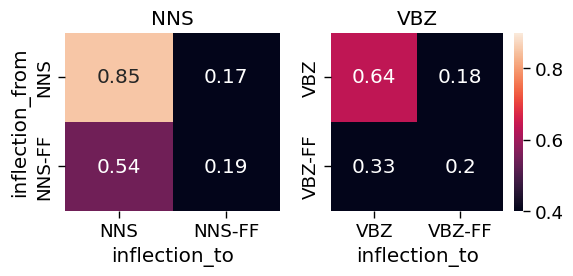

In [115]:
focus_weak_ff_results = weak_ff_results.query("base_model_name == @focus_base_model and model_name == @focus_model and equivalence == @focus_equivalence")

weak_ff_results_summary2 = focus_weak_ff_results.groupby(["inflection_from", "inflection_to"]) \
    [["correct", "gt_label_rank", "gt_distance"]].mean().reset_index()

weak_ff_results_summary2["transfer_label"] = weak_ff_results_summary2.inflection_from + " -> " + weak_ff_results_summary2.inflection_to

# add in data for NNS->NNS and VBZ->VBZ
weak_ff_results_summary2 = pd.concat([weak_ff_results_summary2, nnvb_results_summary2.query("inflection_from == inflection_to and model_label == 'Word'")], axis=0)

weak_ff_results_summary2["base_inflection"] = weak_ff_results_summary2.inflection_from.str.replace("-FF", "")

weak_ff_results_summary2 = weak_ff_results_summary2[weak_ff_results_summary2.base_inflection.isin(plot_inflections)]

g = sns.FacetGrid(weak_ff_results_summary2, col="base_inflection", sharex=False, sharey=False)

def mapfn(data, **kwargs):
    ax = plt.gca()
    sns.heatmap(data.set_index(["inflection_from", "inflection_to"]).correct.unstack("inflection_to"),
                vmin=main_plot_vmin, vmax=main_plot_vmax, annot=True, ax=ax)

g.map_dataframe(mapfn)

for i, ax in enumerate(g.axes.flat):
    ax.set_title(ax.get_title().replace("base_inflection = ", ""))
    if i > 0:
        ax.set_ylabel("")
    if i < len(g.axes.flat) - 1:
        ax.collections[0].colorbar.remove()

g.fig.tight_layout()
g.fig.savefig(f"{output_dir}/ff_results_weak.pdf")

In [116]:
weak_ff_results[weak_ff_results.inflection_to == "NNS-FF"].groupby("base_to").predicted_label.value_counts().to_csv("weak_results.csv")

In [117]:
weak_ff_results.query("base_to == 'den'")[["base_from", "allomorph_from", "predicted_label", "gt_label"]]

,base_from,allomorph_from,predicted_label,gt_label
1039,corn,Z,stedman,dense
1137,canoe,Z,attendants,dense
1138,mystery,Z,advances,dense
1182,senior,Z,demanded,dense
1223,proposition,Z,evident,dense
...,...,...,...,...
955597,per,S,desk,dense
955598,dew,S,dense,dense
955780,ran,S,dense,dense
955834,joy,S,dance,dense


/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


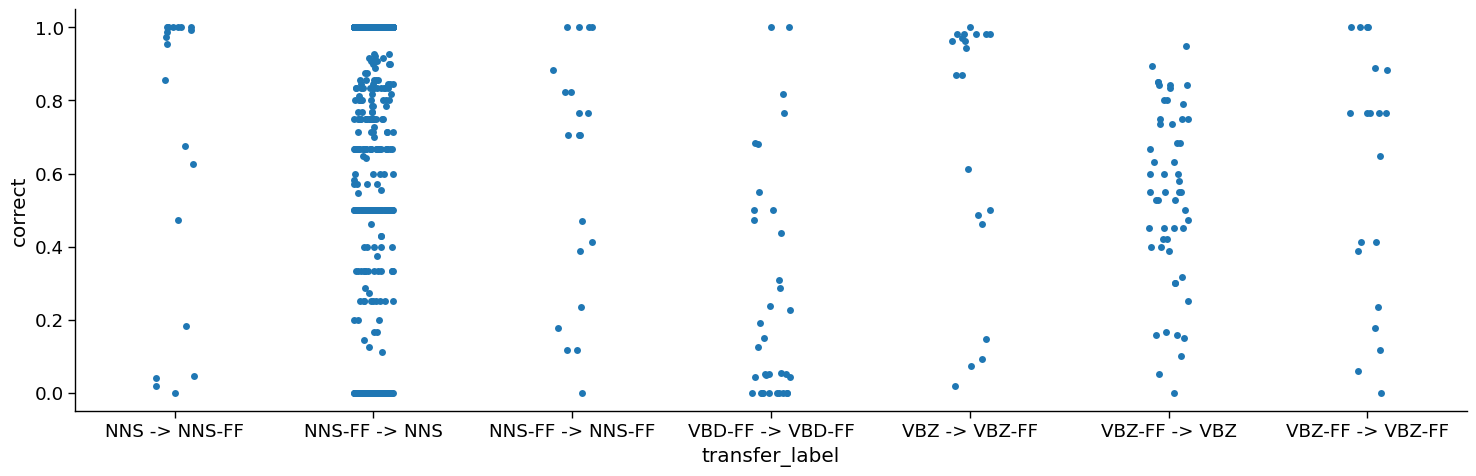

In [118]:
sns.catplot(data=focus_ff_results.groupby(["transfer_label", "base_to"]).correct.mean().reset_index(),
            x="transfer_label", y="correct", aspect=3)

In [119]:
focus_ff_results.allomorph_to.value_counts()

allomorph_to
Z       5265
S       1360
IH Z     780
D        618
T          8
Name: count, dtype: int64

In [120]:
focus_ff_results.query("base_to == 'to'")[["gt_label", "allomorph_to"]].iloc[0]

gt_label        tis
allomorph_to      Z
Name: 812520, dtype: object

In [121]:
focus_ff_results.query("base_to == 'why'")

,experiment,equivalence,model_name,base_model_name,Unnamed: 1,group,from_equiv_label,to_equiv_label,base_from,base_to,...,from_base_freq,to_base_freq,from_inflected_freq,to_inflected_freq,from_freq,to_freq,transfer_label,is_strong,from_freq_bin,to_freq_bin
812516,NNS_Z-to-NNS-FF-Z,word_broad_10frames_fixedlen25,ff_32,w2v2_8,12,None,"('couple', 'couples')","('why', 'wise')",couple,why,...,11.434646,11.951054,10.397196,10.551855,10.915921,11.251455,NNS -> NNS-FF,True,Q2,Q3
812546,NNS_Z-to-NNS-FF-Z,word_broad_10frames_fixedlen25,ff_32,w2v2_8,42,None,"('town', 'towns')","('why', 'wise')",town,why,...,11.324986,11.951054,10.350608,10.551855,10.837797,11.251455,NNS -> NNS-FF,True,Q2,Q3
812566,NNS_Z-to-NNS-FF-Z,word_broad_10frames_fixedlen25,ff_32,w2v2_8,62,None,"('kingdom', 'kingdoms')","('why', 'wise')",kingdom,why,...,10.417491,11.951054,9.150511,10.551855,9.784001,11.251455,NNS -> NNS-FF,True,Q1,Q3
812567,NNS_Z-to-NNS-FF-Z,word_broad_10frames_fixedlen25,ff_32,w2v2_8,63,None,"('buffalo', 'buffaloes')","('why', 'wise')",buffalo,why,...,10.359719,11.951054,8.863492,10.551855,9.611605,11.251455,NNS -> NNS-FF,True,Q1,Q3
812575,NNS_Z-to-NNS-FF-Z,word_broad_10frames_fixedlen25,ff_32,w2v2_8,71,None,"('community', 'communities')","('why', 'wise')",community,why,...,11.443167,11.951054,10.684183,10.551855,11.063675,11.251455,NNS -> NNS-FF,True,Q3,Q3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
830456,false_friends,word_broad_10frames_fixedlen25,ff_32,w2v2_8,5104,"(VBZ-FF-Z,)","('unaware', 'unawares', 'Z')","('why', 'wise', 'Z')",unaware,why,...,9.997639,11.951054,8.608220,10.551855,9.302929,11.251455,VBZ-FF -> VBZ-FF,True,Q1,Q3
830491,false_friends,word_broad_10frames_fixedlen25,ff_32,w2v2_8,5139,"(VBZ-FF-Z,)","('afterward', 'afterwards', 'Z')","('why', 'wise', 'Z')",afterward,why,...,10.177091,11.951054,10.215828,10.551855,10.196460,11.251455,VBZ-FF -> VBZ-FF,True,Q1,Q3
830557,false_friends,word_broad_10frames_fixedlen25,ff_32,w2v2_8,5205,"(VBZ-FF-Z,)","('fro', 'froze', 'Z')","('why', 'wise', 'Z')",fro,why,...,9.449758,11.951054,9.599446,10.551855,9.524602,11.251455,VBZ-FF -> VBZ-FF,True,Q1,Q3
830596,false_friends,word_broad_10frames_fixedlen25,ff_32,w2v2_8,5244,"(VBZ-FF-Z,)","('upward', 'upwards', 'Z')","('why', 'wise', 'Z')",upward,why,...,9.862802,11.951054,9.572007,10.551855,9.717405,11.251455,VBZ-FF -> VBZ-FF,True,Q1,Q3


In [122]:
focus_ff_results.query("transfer_label == 'NNS -> NNS-FF'").groupby("base_to").correct.mean().sort_values()

base_to
to             0.000000
why            0.017241
are            0.040650
fro            0.044248
the            0.182482
tho            0.473684
sick           0.625000
their          0.675926
louis          0.857143
who            0.953704
adam           0.972973
philip         0.988506
surrounding    0.992754
beside         1.000000
her            1.000000
backward       1.000000
toward         1.000000
afterward      1.000000
upward         1.000000
unaware        1.000000
Name: correct, dtype: float64

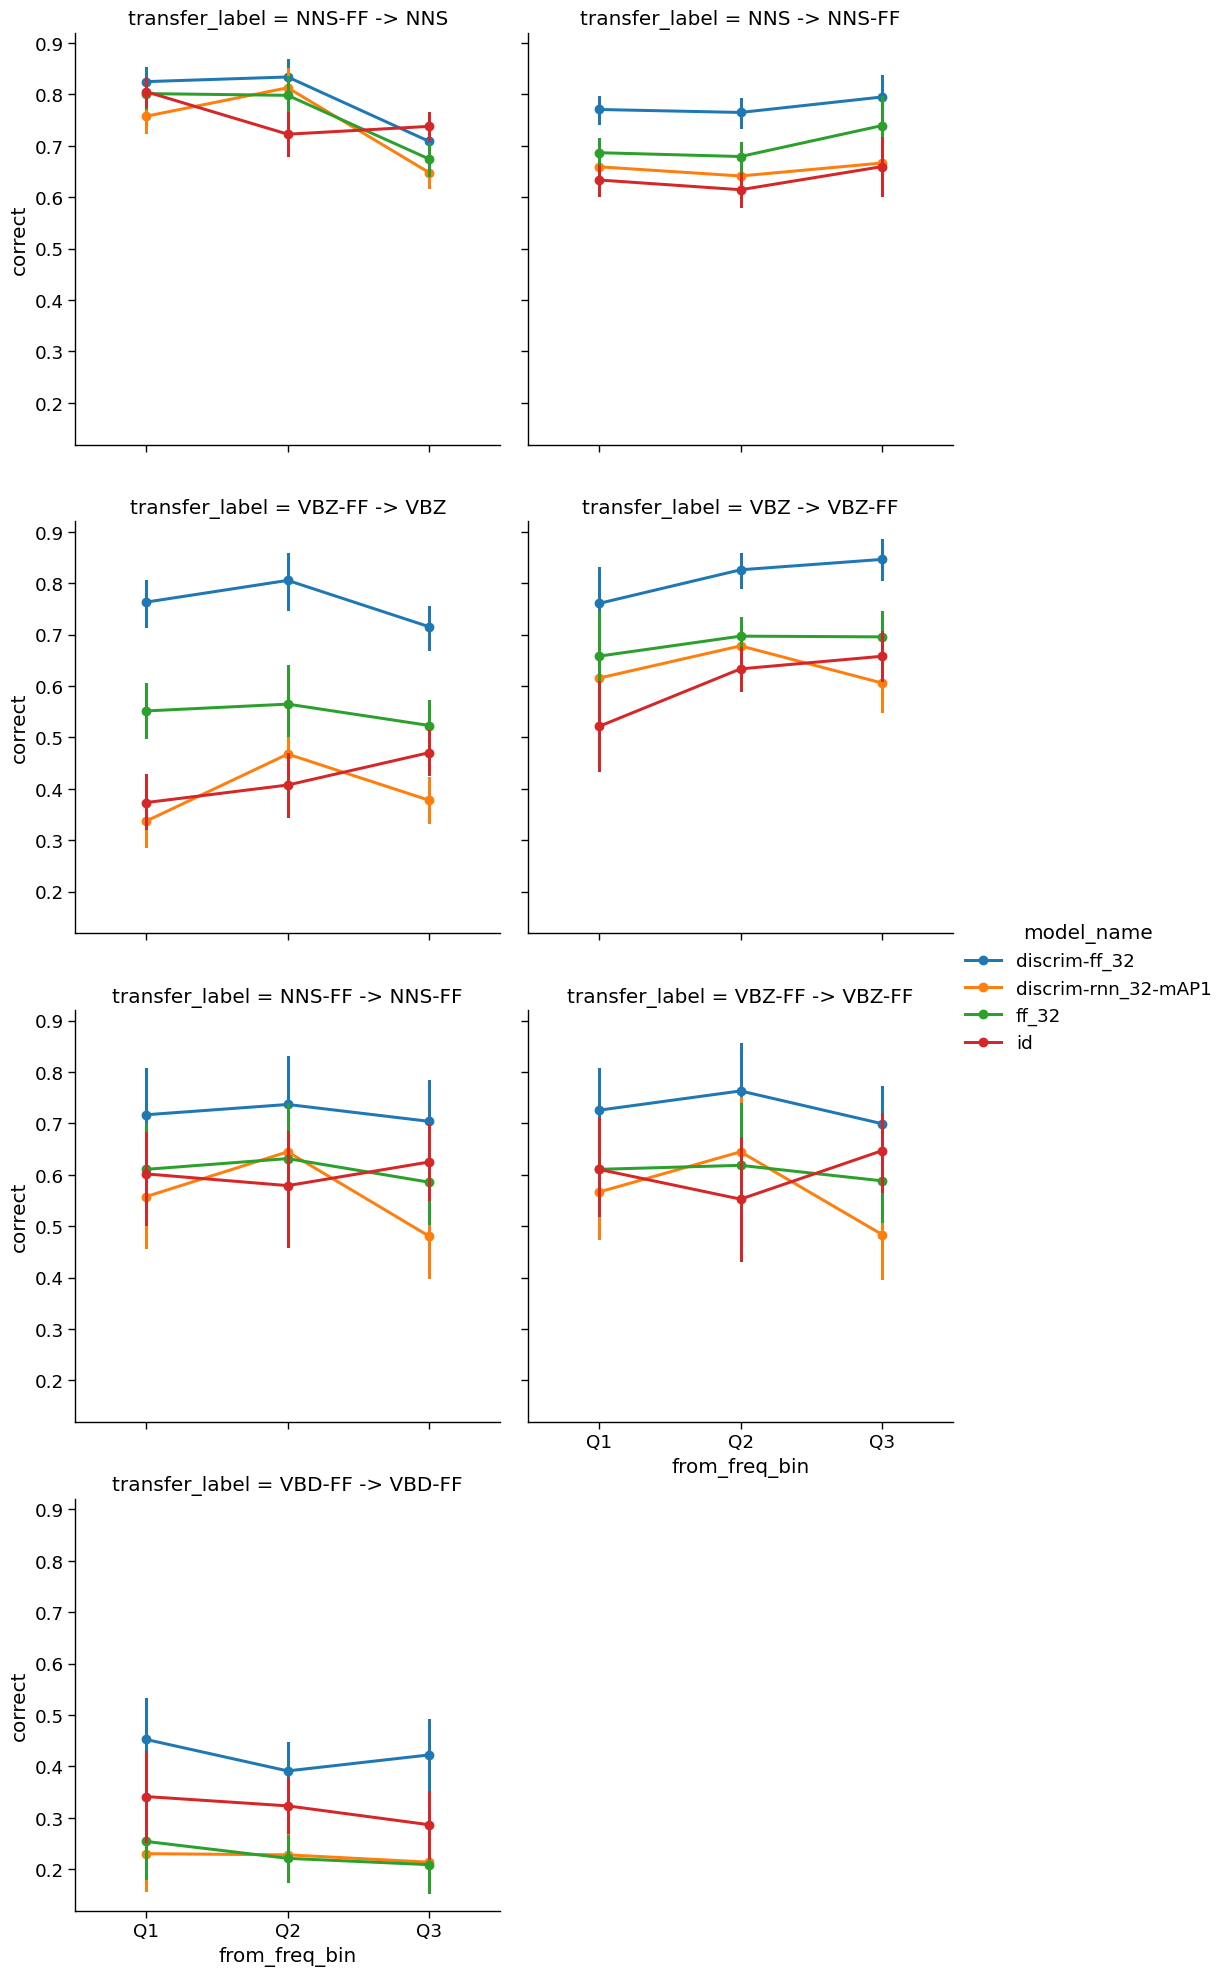

In [123]:
sns.catplot(data=all_ff_results.query("base_model_name == 'w2v2_8'").reset_index(),
            x="from_freq_bin", y="correct", hue="model_name",
            col="transfer_label", col_wrap=2, kind="point")

In [124]:
all_ff_results.query("base_model_name == 'w2v2_8' and model_name == 'ff_32' and transfer_label == 'NNS -> NNS-FF'").groupby(["to_freq_bin", "base_to"]).correct.agg(["count", "mean"]).dropna().groupby("to_freq_bin").apply(lambda xs: xs.sort_values("mean"))

/tmp/ipykernel_3569269/2092683813.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  all_ff_results.query("base_model_name == 'w2v2_8' and model_name == 'ff_32' and transfer_label == 'NNS -> NNS-FF'").groupby(["to_freq_bin", "base_to"]).correct.agg(["count", "mean"]).dropna().groupby("to_freq_bin").apply(lambda xs: xs.sort_values("mean"))
/tmp/ipykernel_3569269/2092683813.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  all_ff_results.query("base_model_name == 'w2v2_8' and model_name == 'ff_32' and transfer_label == 'NNS -> NNS-FF'").groupby(["to_freq_bin", "base_to"]).correct.agg(["count", "mean"]).dropn

count      mean
to_freq_bin to_freq_bin base_to                     
Q1          Q1          fro            113  0.044248
                        philip          87  0.988506
                        surrounding    138  0.992754
                        backward       129  1.000000
                        afterward      117  1.000000
                        unaware        123  1.000000
                        upward         108  1.000000
Q2          Q2          louis          133  0.857143
                        adam           111  0.972973
                        beside         122  1.000000
                        toward         132  1.000000
Q3          Q3          to             111  0.000000
                        why            116  0.017241
                        are            123  0.040650
                        the            137  0.182482
                        tho            114  0.473684
                        sick            80  0.625000
                        their          108  0.675926
                        who            108  0.953704
                        her            108  1.000000

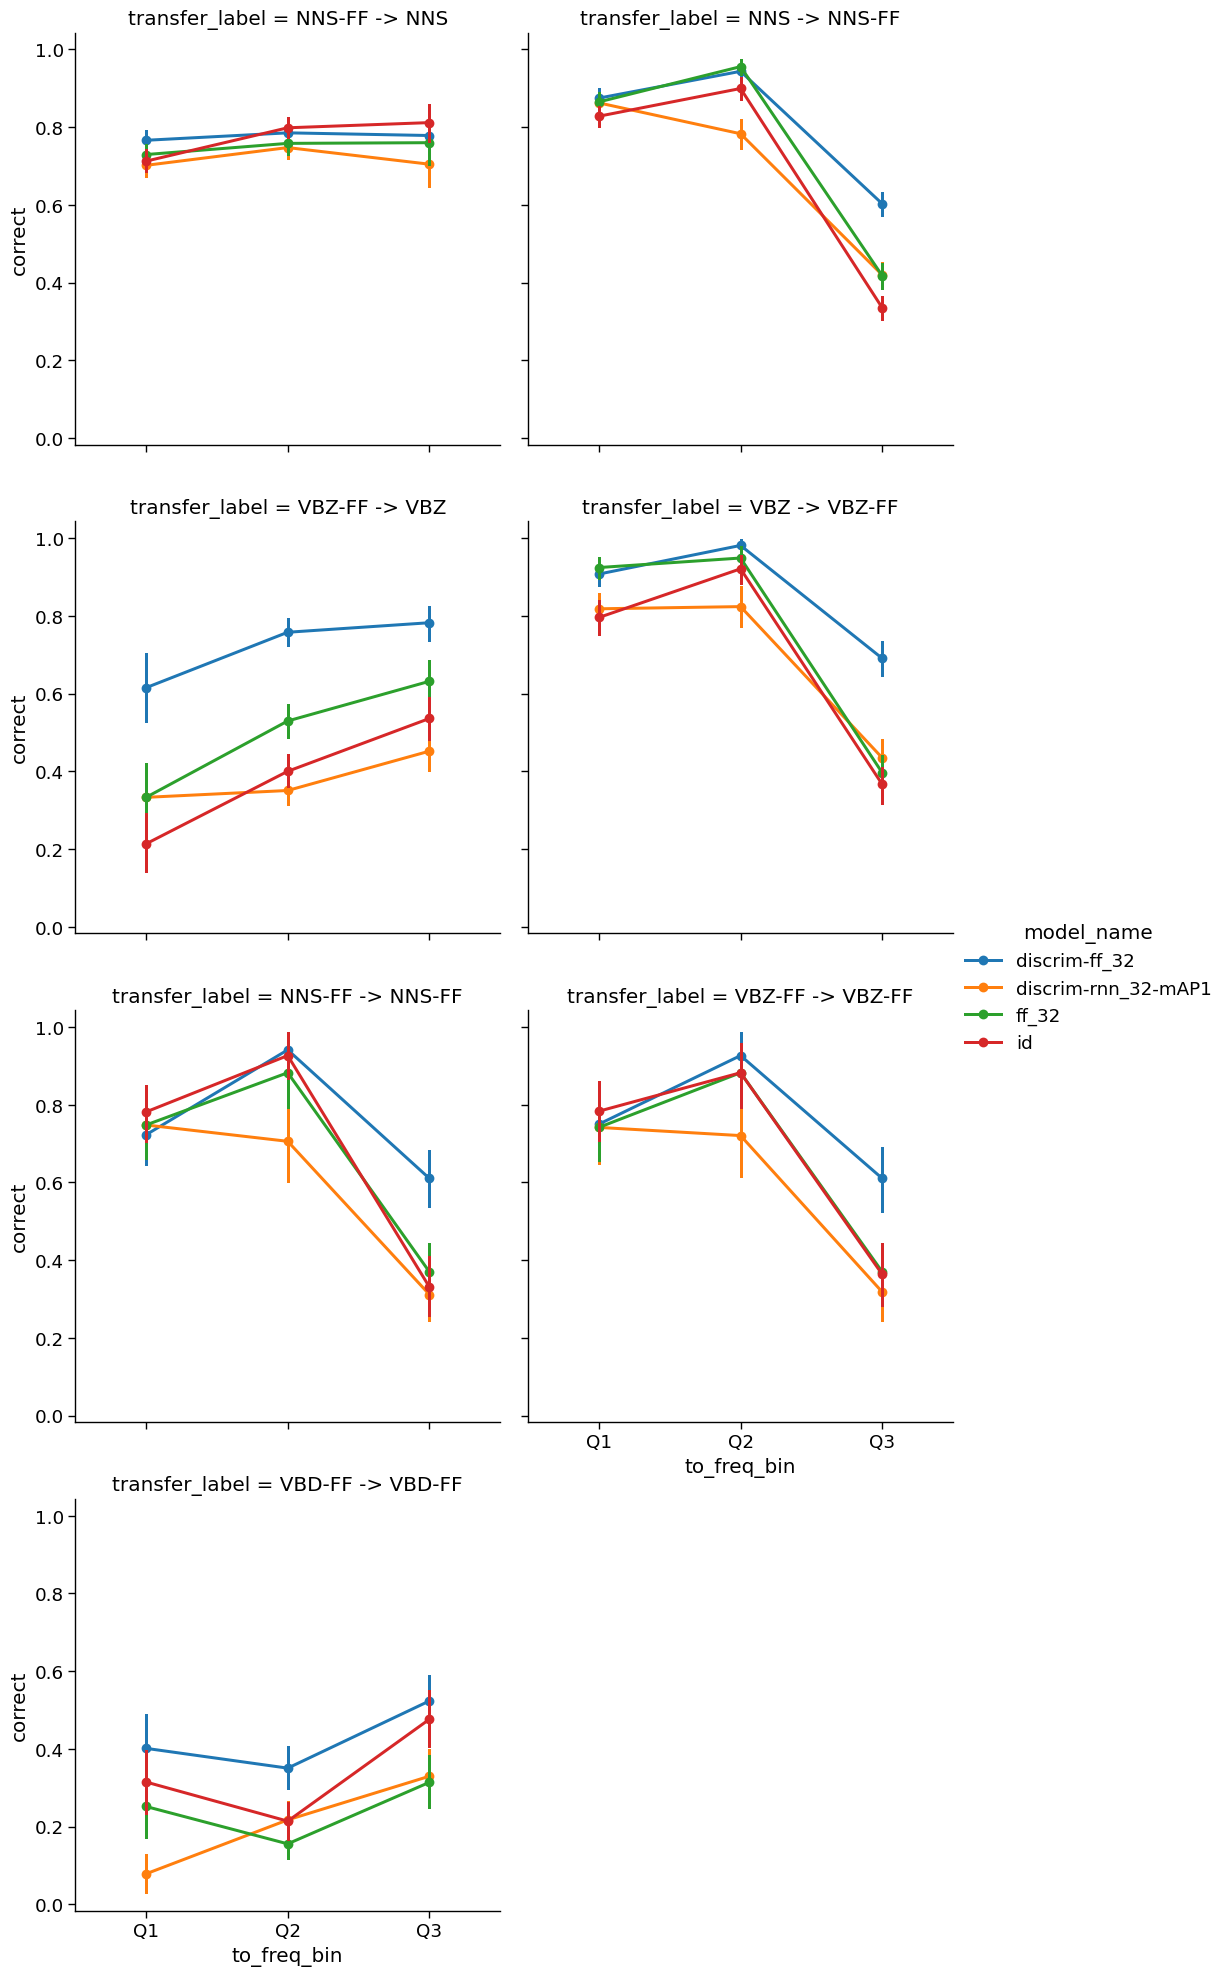

In [125]:
sns.catplot(data=all_ff_results.query("base_model_name == 'w2v2_8'").reset_index(),
            x="to_freq_bin", y="correct", hue="model_name",
            col="transfer_label", col_wrap=2, kind="point")

## Controlled VBD analysis

In [52]:
all_vbd_results = all_results.query("experiment == 'regular' and inflection_from == 'VBD'")
all_vbd_results = pd.merge(all_vbd_results, mca.rename(columns={"base": "base_from", "inflection": "inflection_from", "most_common_allomorph": "allomorph_from"}),
               on=["base_from", "inflection_from"], how="left")
all_vbd_results = pd.merge(all_vbd_results, mca.rename(columns={"base": "base_to", "inflection": "inflection_to", "most_common_allomorph": "allomorph_to"}),
               on=["base_to", "inflection_to"], how="left")
all_vbd_results[["allomorph_from", "allomorph_to"]].value_counts()

allomorph_from  allomorph_to
D               D               9044
T               D               3914
D               IH D            3876
IH D            D               3838
D               T               3800
                                ... 
EH P T          D                 38
                EH L D            38
                EH L T            38
                EY M              38
                AE T              38
Name: count, Length: 748, dtype: int64

In [55]:
keep_vbd_allomorphs = all_vbd_results.allomorph_from.value_counts().head(3).index
all_vbd_results = all_vbd_results[all_vbd_results.allomorph_from.isin(keep_vbd_allomorphs)
                                  & all_vbd_results.allomorph_to.isin(keep_vbd_allomorphs)]

In [56]:
# Add frequency information

all_vbd_results["inflected_from"] = all_vbd_results.from_equiv_label.apply(lambda x: eval(x)[1])
all_vbd_results["inflected_to"] = all_vbd_results.to_equiv_label.apply(lambda x: eval(x)[1])

all_vbd_results = pd.merge(all_vbd_results, word_freq_df["LogFreq"].rename("from_base_freq"),
                           left_on="base_from", right_index=True)
all_vbd_results = pd.merge(all_vbd_results, word_freq_df["LogFreq"].rename("to_base_freq"),
                           left_on="base_to", right_index=True)
all_vbd_results = pd.merge(all_vbd_results, word_freq_df["LogFreq"].rename("from_inflected_freq"),
                            left_on="inflected_from", right_index=True)
all_vbd_results = pd.merge(all_vbd_results, word_freq_df["LogFreq"].rename("to_inflected_freq"),
                            left_on="inflected_to", right_index=True)

all_vbd_results["from_freq"] = all_vbd_results[["from_base_freq", "from_inflected_freq"]].mean(axis=1)
all_vbd_results["to_freq"] = all_vbd_results[["to_base_freq", "to_inflected_freq"]].mean(axis=1)

_, vbd_frequency_bins = pd.qcut(pd.concat([all_vbd_results.to_freq, all_vbd_results.from_freq]), q=3, retbins=True)
all_vbd_results["from_freq_bin"] = pd.cut(all_vbd_results.from_freq, bins=vbd_frequency_bins, labels=[f"Q{i}" for i in range(1, 4)])
all_vbd_results["to_freq_bin"] = pd.cut(all_vbd_results.to_freq, bins=vbd_frequency_bins, labels=[f"Q{i}" for i in range(1, 4)])

In [57]:
def summarize_vbd_run(rows):
    rows["source_label"] = rows.inflection_from + " " + rows.allomorph_from
    rows["target_label"] = rows.inflection_to + " " + rows.allomorph_to

    rows["transfer_label"] = rows.inflection_from + " -> " + rows.inflection_to
    rows["phon_label"] = rows.allomorph_from + " -> " + rows.allomorph_to

    return rows

summary_groupers = ["inflection_from", "inflection_to", "allomorph_from", "allomorph_to"]
vbd_results_summary = all_vbd_results.groupby(run_groupers + summary_groupers) \
    .correct.agg(["count", "mean"]) \
    .reset_index(summary_groupers) \
    .groupby(run_groupers, group_keys=False) \
    .apply(summarize_vbd_run) \
    .reset_index()

vbd_results_summary

,base_model_name,model_name,equivalence,inflection_from,inflection_to,allomorph_from,allomorph_to,count,mean,source_label,target_label,transfer_label,phon_label
0,w2v2_0,discrim-ff_32,word_broad_10frames_fixedlen25,VBD,VBD,D,D,238,0.079832,VBD D,VBD D,VBD -> VBD,D -> D
1,w2v2_0,discrim-ff_32,word_broad_10frames_fixedlen25,VBD,VBD,D,IH D,102,0.019608,VBD D,VBD IH D,VBD -> VBD,D -> IH D
2,w2v2_0,discrim-ff_32,word_broad_10frames_fixedlen25,VBD,VBD,D,T,100,0.050000,VBD D,VBD T,VBD -> VBD,D -> T
3,w2v2_0,discrim-ff_32,word_broad_10frames_fixedlen25,VBD,VBD,IH D,D,101,0.049505,VBD IH D,VBD D,VBD -> VBD,IH D -> D
4,w2v2_0,discrim-ff_32,word_broad_10frames_fixedlen25,VBD,VBD,IH D,IH D,37,0.054054,VBD IH D,VBD IH D,VBD -> VBD,IH D -> IH D
...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,w2v2_pc_8,discrim-rnn_32-pc-mAP1,word_broad_10frames_fixedlen25,VBD,VBD,IH D,IH D,37,0.513514,VBD IH D,VBD IH D,VBD -> VBD,IH D -> IH D
338,w2v2_pc_8,discrim-rnn_32-pc-mAP1,word_broad_10frames_fixedlen25,VBD,VBD,IH D,T,37,0.594595,VBD IH D,VBD T,VBD -> VBD,IH D -> T
339,w2v2_pc_8,discrim-rnn_32-pc-mAP1,word_broad_10frames_fixedlen25,VBD,VBD,T,D,103,0.582524,VBD T,VBD D,VBD -> VBD,T -> D
340,w2v2_pc_8,discrim-rnn_32-pc-mAP1,word_broad_10frames_fixedlen25,VBD,VBD,T,IH D,34,0.382353,VBD T,VBD IH D,VBD -> VBD,T -> IH D


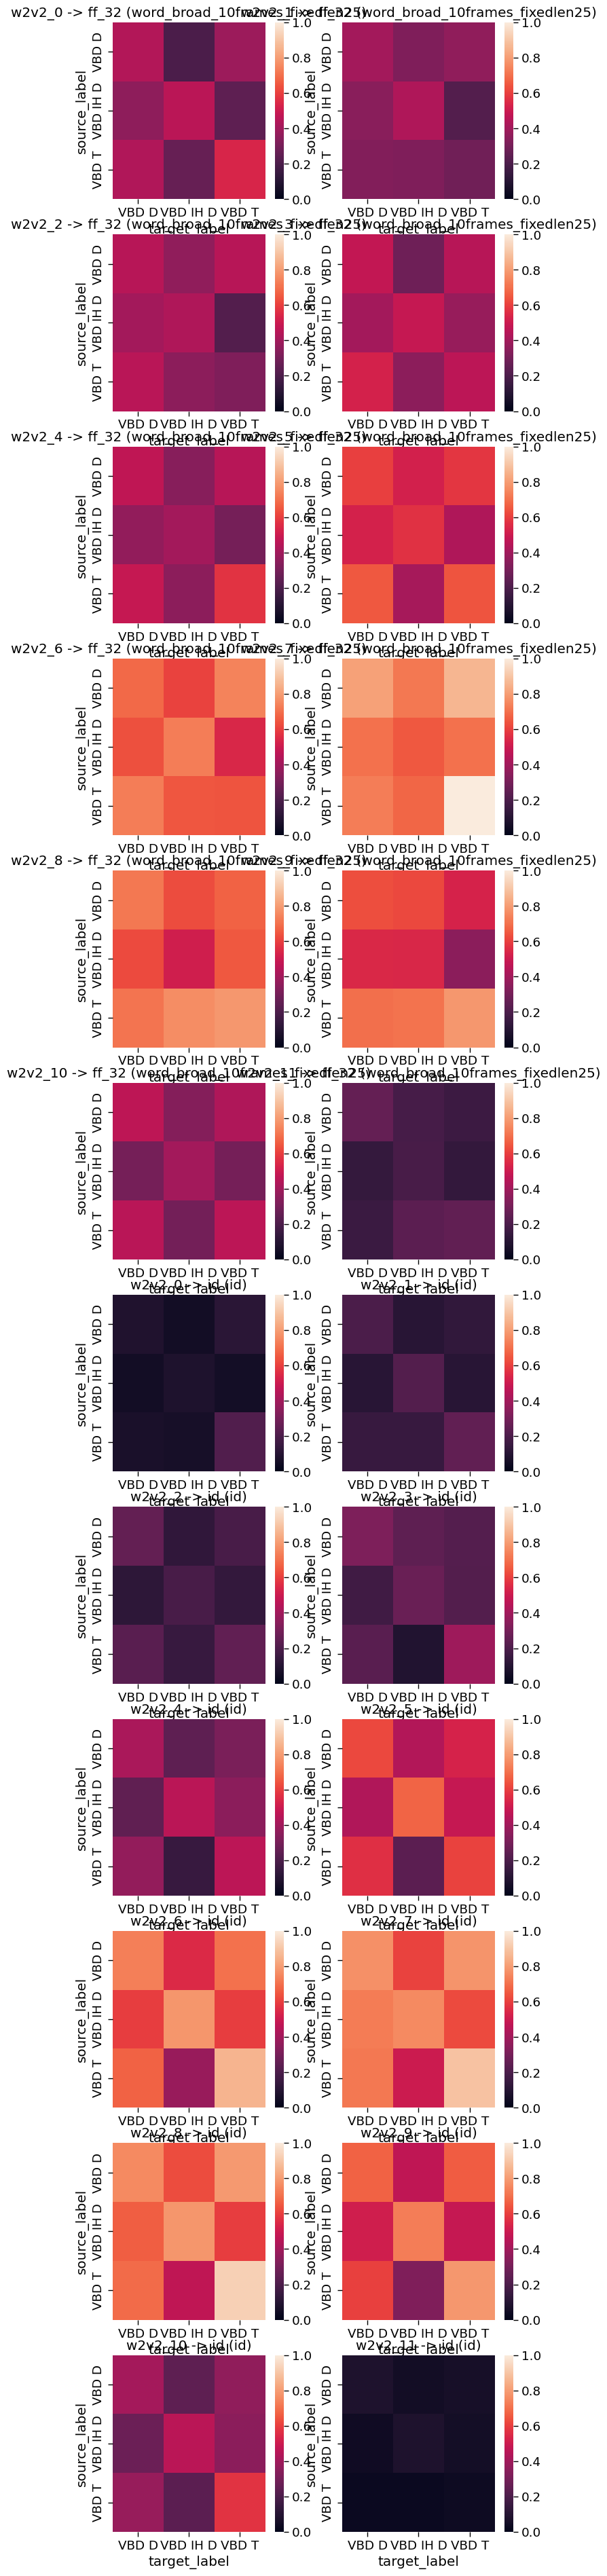

In [58]:
plot_results = []
for base_model_name, model_name, equivalence in plot_runs:
    results_i = vbd_results_summary.query("base_model_name == @base_model_name and model_name == @model_name and equivalence == @equivalence")
    if len(results_i) > 0:
        plot_results.append(results_i)
num_plot_runs = len(plot_results)

ncols = 2
nrows = int(np.ceil(num_plot_runs / ncols))
f, axs = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))

for ax, results_i in zip(axs.flat, plot_results):
    sns.heatmap(results_i.set_index(["source_label", "target_label"])["mean"].unstack(),
                vmin=0, vmax=1, ax=ax)
    key_row = results_i.iloc[0]
    ax.set_title(f"{key_row.base_model_name} -> {key_row.model_name} ({key_row.equivalence})")

### Focused plots

In [61]:
focus_base_model, focus_model, focus_equivalence = main_plot_run
foil_base_model, foil_model, foil_equivalence = "w2v2_8", "id", "id"

vbd_focus = all_vbd_results.query("base_model_name == @focus_base_model and model_name == @focus_model and equivalence == @focus_equivalence")
vbd_foil = all_vbd_results.query("base_model_name == @foil_base_model and model_name == @foil_model and equivalence == @foil_equivalence")
vbd_focus["model_label"] = "Word"
vbd_foil["model_label"] = "Wav2Vec"

vbd_focus = pd.concat([vbd_focus, vbd_foil])

allomorph_labels = {"D": "d", "T": "t", "IH D": "ɪd"}
vbd_focus["allomorph_from"] = vbd_focus.allomorph_from.map(allomorph_labels)
vbd_focus["allomorph_to"] = vbd_focus.allomorph_to.map(allomorph_labels)
vbd_focus

/tmp/ipykernel_1658110/2170661113.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vbd_focus["model_label"] = "Word"
/tmp/ipykernel_1658110/2170661113.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vbd_foil["model_label"] = "Wav2Vec"


,equivalence,model_name,base_model_name,experiment,Unnamed: 1,group,from_equiv_label,to_equiv_label,base_from,base_to,...,inflected_to,from_base_freq,to_base_freq,from_inflected_freq,to_inflected_freq,from_freq,to_freq,from_freq_bin,to_freq_bin,model_label
36181,word_broad_10frames_fixedlen25,ff_32,w2v2_8,regular,2047,"(VBD, False)","('hide', 'hid')","('make', 'made')",hide,make,...,made,10.550157,12.179715,9.770869,11.984212,10.160513,12.081964,Q2,Q3,Word
36304,word_broad_10frames_fixedlen25,ff_32,w2v2_8,regular,2170,"(VBD, False)","('lead', 'led')","('dwell', 'dwelt')",lead,dwell,...,dwelt,11.313276,9.782653,11.130552,8.856543,11.221914,9.319598,Q3,Q1,Word
36412,word_broad_10frames_fixedlen25,ff_32,w2v2_8,regular,2278,"(VBD, False)","('have', 'had')","('build', 'built')",have,build,...,built,12.789006,11.056440,12.430472,10.994846,12.609739,11.025643,Q3,Q3,Word
36512,word_broad_10frames_fixedlen25,ff_32,w2v2_8,regular,2378,"(VBD, False)","('lend', 'lent')","('make', 'made')",lend,make,...,made,9.942098,12.179715,9.942098,11.984212,9.942098,12.081964,Q2,Q3,Word
36570,word_broad_10frames_fixedlen25,ff_32,w2v2_8,regular,2436,"(VBD, False)","('bend', 'bent')","('send', 'sent')",bend,send,...,sent,10.192874,11.259553,10.052710,11.206948,10.122792,11.233250,Q2,Q3,Word
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,id,id,w2v2_8,regular,3861,"(VBD, True)","('hope', 'hoped')","('assure', 'assured')",hope,assure,...,assured,11.818844,9.948947,10.457902,10.166242,11.138373,10.057594,Q3,Q2,Wav2Vec
69996,id,id,w2v2_8,regular,3862,"(VBD, True)","('establish', 'established')","('smoke', 'smoked')",establish,smoke,...,smoked,10.278730,10.723116,10.563288,10.233532,10.421009,10.478324,Q2,Q2,Wav2Vec
69997,id,id,w2v2_8,regular,3863,"(VBD, True)","('neglect', 'neglected')","('exceed', 'exceeded')",neglect,exceed,...,exceeded,9.942098,9.837206,9.931619,9.778481,9.936859,9.807844,Q2,Q1,Wav2Vec
69998,id,id,w2v2_8,regular,3864,"(VBD, True)","('include', 'included')","('experience', 'experienced')",include,experience,...,experienced,11.200967,11.391040,11.019406,10.650964,11.110187,11.021002,Q3,Q3,Wav2Vec


In [62]:
vbd_results_summary = vbd_focus.groupby(["model_label", "inflection_from", "inflection_to",
                                             "allomorph_from", "allomorph_to"]) \
    .correct.agg(["count", "mean"]) \
    .query("count >= 0") \
    .reset_index()

vbd_results_summary["source_label"] = vbd_results_summary.inflection_from + "\n" + vbd_results_summary.allomorph_from
vbd_results_summary["target_label"] = vbd_results_summary.inflection_to + "\n" + vbd_results_summary.allomorph_to

vbd_results_summary["transfer_label"] = vbd_results_summary.inflection_from + " -> " + vbd_results_summary.inflection_to
vbd_results_summary["phon_label"] = vbd_results_summary.allomorph_from + " " + vbd_results_summary.allomorph_to

# only retain cases where we have data in both transfer directions from source <-> target within inflection
vbd_results_summary["complement_exists"] = vbd_results_summary.apply(lambda row: len(vbd_results_summary.query("source_label == @row.target_label and target_label == @row.source_label")), axis=1)
vbd_results_summary = vbd_results_summary.query("complement_exists > 0").drop(columns=["complement_exists"])

vbd_results_summary

,model_label,inflection_from,inflection_to,allomorph_from,allomorph_to,count,mean,source_label,target_label,transfer_label,phon_label
0,Wav2Vec,VBD,VBD,d,d,238,0.756303,VBD\nd,VBD\nd,VBD -> VBD,d d
1,Wav2Vec,VBD,VBD,d,t,100,0.790000,VBD\nd,VBD\nt,VBD -> VBD,d t
2,Wav2Vec,VBD,VBD,d,ɪd,102,0.627451,VBD\nd,VBD\nɪd,VBD -> VBD,d ɪd
3,Wav2Vec,VBD,VBD,t,d,103,0.689320,VBD\nt,VBD\nd,VBD -> VBD,t d
4,Wav2Vec,VBD,VBD,t,t,28,0.928571,VBD\nt,VBD\nt,VBD -> VBD,t t
5,Wav2Vec,VBD,VBD,t,ɪd,34,0.470588,VBD\nt,VBD\nɪd,VBD -> VBD,t ɪd
6,Wav2Vec,VBD,VBD,ɪd,d,101,0.663366,VBD\nɪd,VBD\nd,VBD -> VBD,ɪd d
7,Wav2Vec,VBD,VBD,ɪd,t,37,0.594595,VBD\nɪd,VBD\nt,VBD -> VBD,ɪd t
8,Wav2Vec,VBD,VBD,ɪd,ɪd,37,0.783784,VBD\nɪd,VBD\nɪd,VBD -> VBD,ɪd ɪd
9,Word,VBD,VBD,d,d,238,0.718487,VBD\nd,VBD\nd,VBD -> VBD,d d


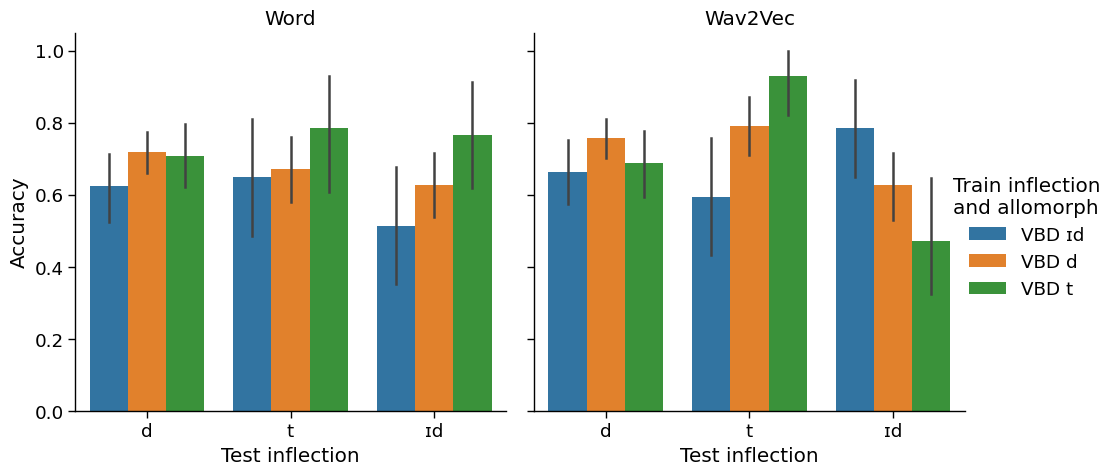

In [65]:
vbd_focus_bar = vbd_focus.assign(source_label=lambda xs: xs.inflection_from + " " + xs.allomorph_from)
order = vbd_focus_bar.groupby("source_label").correct.mean().sort_values().index
g = sns.catplot(data=vbd_focus_bar, x="allomorph_to", hue="source_label", y="correct", col="model_label", kind="bar")
g._legend.set_title("Train inflection\nand allomorph")

for ax in g.axes.flat:
    ax.set_title(ax.get_title().split("=")[1].strip())
    ax.set_xlabel("Test inflection")
    ax.set_ylabel("Accuracy")

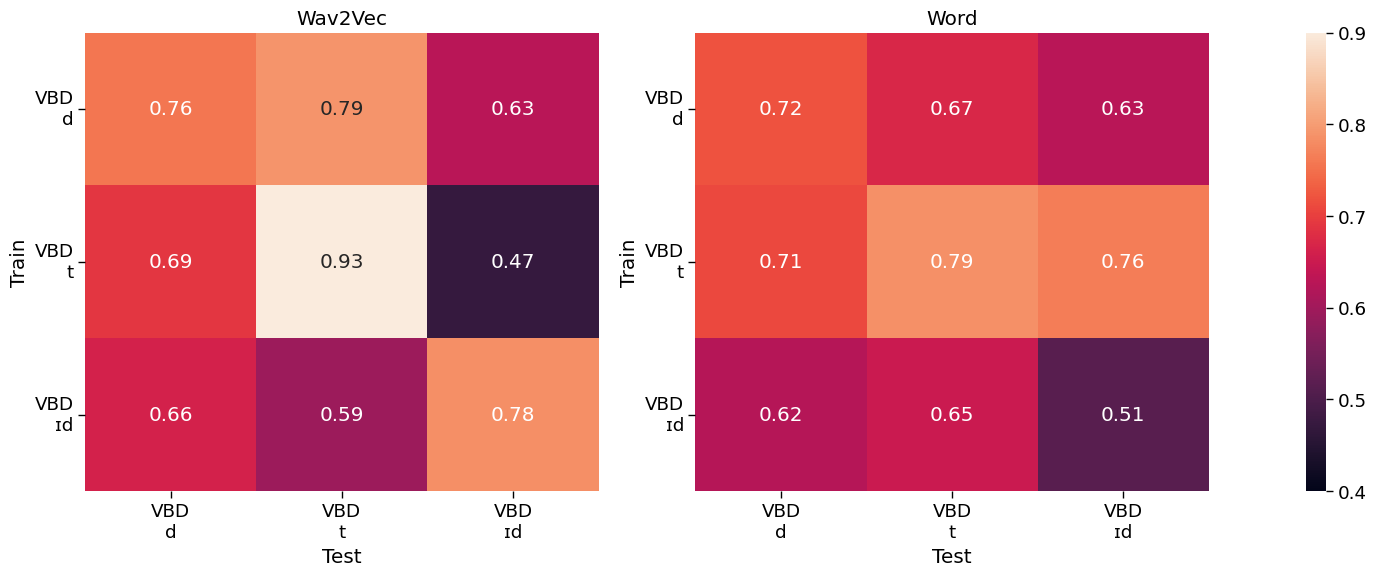

In [67]:
# f, ax = plt.subplots(1, 2, figsize=(7 * 2, 6))

f, axs = plt.subplots(1, 3, figsize=(7 * 2, 6), gridspec_kw={'width_ratios': [1, 1, 0.04]})
for i, (ax, (model_label, rows)) in enumerate(zip(axs, vbd_results_summary.groupby("model_label"))):
    cbar_ax = None
    if i == 1:
        cbar_ax = axs.flat[-1]

    ax.set_title(model_label)
    sns.heatmap(rows.set_index(["source_label", "target_label"]).sort_index()["mean"].unstack("target_label"),
                vmin=main_plot_vmin, vmax=main_plot_vmax, annot=True, ax=ax,
                cbar=i == 1, cbar_ax=cbar_ax)

    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_ylabel("Train")
    ax.set_xlabel("Test")

f.tight_layout()
f.savefig(f"{output_dir}/vbd_allomorphs.pdf")

## V3

In [73]:
plot_inflections_v3 = ["non", "agent", "comp"]

In [74]:
v3_cross_instances = pd.read_parquet("outputs/analogy_v3/inputs/librispeech-train-clean-100/w2v2/all_cross_instances.parquet")

### Pre-compute metadata

In [75]:
base_prons = v3_cross_instances.groupby("base").base_phones.value_counts().groupby("base").head(1) \
    .reset_index().drop(columns=["count"])

from src.utils import syllabifier
base_prons["num_syllables"] = base_prons.base_phones.apply(
    lambda phones: len(syllabifier.syllabify(syllabifier.English, phones)))

### Load results

In [76]:
all_results_v3 = concat_csv_with_indices(
        "outputs/analogy_v3/runs/**/experiment_results.csv",
        [lambda p: p.parent.name, lambda p: p.parents[1].name,
            lambda p: p.parents[2].name],
        ["equivalence", "model_name", "base_model_name"]) \
    .droplevel(-1).reset_index()

In [77]:
all_id_results_v3 = concat_csv_with_indices(
        "outputs/analogy_v3/runs_id/**/experiment_results.csv",
        [lambda p: p.parent.name],
        ["base_model_name"]) \
    .droplevel(-1).reset_index()
all_id_results_v3["model_name"] = "id"
all_id_results_v3["equivalence"] = "id"

In [78]:
all_results_v3 = pd.concat([all_results_v3, all_id_results_v3], ignore_index=True)

In [81]:
all_results_v3 = pd.merge(all_results_v3,
         base_prons.rename(columns={"base": "base_from",
                                    "num_syllables": "base_from_num_syllables"})
                    .drop(columns=["base_phones"]),
         on="base_from")

all_results_v3 = pd.merge(all_results_v3,
         base_prons.rename(columns={"base": "base_to",
                                    "num_syllables": "base_to_num_syllables"})
                    .drop(columns=["base_phones"]),
         on="base_to")

### load fixes

In [82]:
v3_fixes = pd.read_csv("20250218 annot.csv", index_col=0)
v3_fixes["morph"] = v3_fixes.morph.str.lower()

In [83]:
all_results_v3 = all_results_v3[all_results_v3.base_from.isin(v3_fixes.base) & all_results_v3.base_to.isin(v3_fixes.base)]

In [84]:
all_results_v3 = pd.merge(
    all_results_v3, v3_fixes[["base", "morph"]].rename(columns={"base": "base_from", "morph": "morph_from"}).fillna("non"),
    on=["base_from"], how="inner")
all_results_v3 = pd.merge(
    all_results_v3, v3_fixes[["base", "morph"]].rename(columns={"base": "base_to", "morph": "morph_to"}).fillna("non"),
    on=["base_to"], how="inner")

In [85]:
all_results_v3["inflection_from"] = all_results_v3.morph_from
all_results_v3["inflection_to"] = all_results_v3.morph_to

In [155]:
# DEV
all_results_v3 = all_results_v3[((all_results_v3.base_from_num_syllables == 1) & (all_results_v3.base_to_num_syllables == 1))]

### Layer-wise

In [126]:
all_results_v3.loc[(all_results_v3.experiment == "morph_related") & (all_results_v3.group == "(True,)"), "group_from"] = "morph"
all_results_v3.loc[(all_results_v3.experiment == "morph_related") & (all_results_v3.group == "(True,)"), "group_to"] = "morph"
all_results_v3.loc[(all_results_v3.experiment == "morph_related") & (all_results_v3.group == "(False,)"), "group_from"] = "non"
all_results_v3.loc[(all_results_v3.experiment == "morph_related") & (all_results_v3.group == "(False,)"), "group_to"] = "non"
all_results_v3.loc[(all_results_v3.experiment == "non_to_morph"), "group_from"] = "non"
all_results_v3.loc[(all_results_v3.experiment == "non_to_morph"), "group_to"] = "morph"
all_results_v3.loc[(all_results_v3.experiment == "morph_to_non"), "group_from"] = "morph"
all_results_v3.loc[(all_results_v3.experiment == "morph_to_non"), "group_to"] = "non"

In [127]:
plot_lw_v3 = all_results_v3
plot_lw_v3 = plot_lw_v3.groupby(run_groupers + ["inflection_from", "inflection_to", "base_to"]).correct.mean().reset_index(["inflection_from", "inflection_to", "base_to"])
# get just the relevant runs from plot_runs
plot_lw_v3 = pd.concat([plot_lw_v3.loc[plot_run] for plot_run in plot_runs]).reset_index()
plot_lw_v3["layer"] = plot_lw_v3.base_model_name.str.extract(r"_(\d+)$").astype(int)
plot_lw_v3["label"] = plot_lw_v3.inflection_from + " -> " + plot_lw_v3.inflection_to

plot_lw_v3 = plot_lw_v3[plot_lw_v3.inflection_from.isin(plot_inflections_v3)]

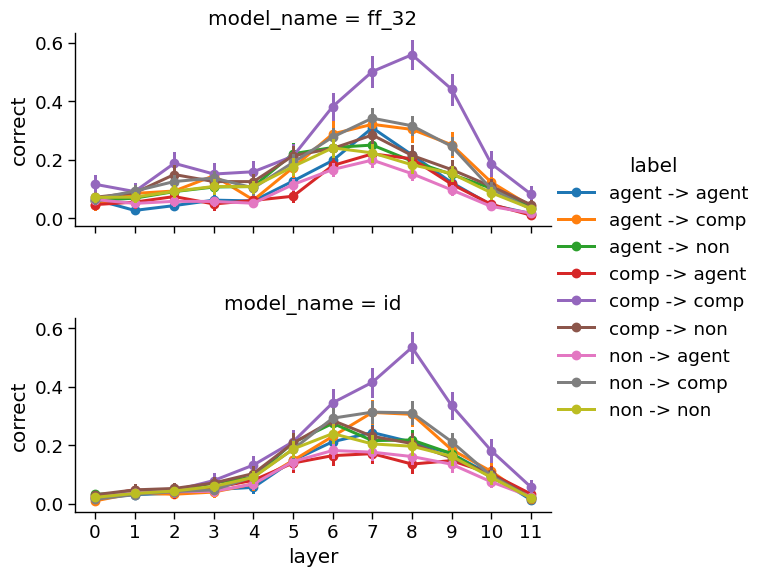

In [128]:
sns.catplot(data=plot_lw_v3, x="layer", y="correct", row="model_name", hue="label",
            kind="point", errorbar="se", height=3, aspect=2)

In [156]:
all_er_results = []

for run, run_results in all_results_v3.groupby(run_groupers):
    transfer_results = pd.Series(run_results.experiment[run_results.experiment.str.contains("_to_")]).unique()
    run_results = run_results.set_index("experiment")

    for expt in transfer_results:
        inflection_from, inflection_to = re.findall(r"(\w+)_to_(\w+)", expt)[0]
        expt_df = run_results.loc[expt].copy()

        num_seen_words = min(len(expt_df.base_from.unique()), len(expt_df.base_to.unique()))
        # DEV
        # if num_seen_words < 10:
        #     print(f"Skipping {expt} due to only {num_seen_words} seen words")
        #     continue

        # expt_df["inflection_from"] = inflection_from
        # expt_df["inflection_to"] = inflection_to

        all_er_results.append(expt_df)

    all_er_results.append(run_results.loc["morph_related"].copy())

all_er_results = pd.concat(all_er_results)

In [157]:
all_er_results["inflected_from"] = all_er_results.from_equiv_label.apply(lambda x: eval(x)[1])
all_er_results["inflected_to"] = all_er_results.to_equiv_label.apply(lambda x: eval(x)[1])
all_er_results["transfer_label"] = all_er_results.inflection_from + " -> " + all_er_results.inflection_to

all_er_results = pd.merge(all_er_results, word_freq_df.LogFreq.rename("from_base_freq"),
                            left_on="base_from", right_index=True)
all_er_results = pd.merge(all_er_results, word_freq_df.LogFreq.rename("from_inflected_freq"),
                            left_on="inflected_from", right_index=True)
all_er_results = pd.merge(all_er_results, word_freq_df.LogFreq.rename("to_base_freq"),
                              left_on="base_to", right_index=True)
all_er_results = pd.merge(all_er_results, word_freq_df.LogFreq.rename("to_inflected_freq"),
                            left_on="inflected_to", right_index=True)

all_er_results["from_freq"] = all_er_results[["from_base_freq", "from_inflected_freq"]].mean(axis=1)
all_er_results["to_freq"] = all_er_results[["to_base_freq", "to_inflected_freq"]].mean(axis=1)

_, er_frequency_bins = pd.qcut(pd.concat([all_er_results.to_freq, all_er_results.from_freq]), q=5, retbins=True)
all_er_results["to_freq_bin"] = pd.cut(all_er_results.to_freq, bins=frequency_bins, labels=[f"Q{i}" for i in range(1, 6)])
all_er_results["from_freq_bin"] = pd.cut(all_er_results.from_freq, bins=frequency_bins, labels=[f"Q{i}" for i in range(1, 6)])

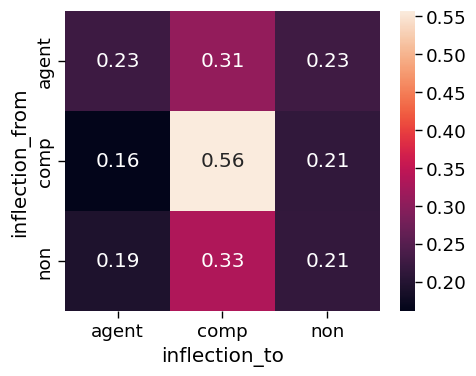

In [158]:
# DEV
focus_base_model, focus_model, focus_equivalence = "w2v2_8", "id", "id"
# focus_base_model, focus_model, focus_equivalence = "w2v2_8", "ff_32", "word_broad_10frames_fixedlen25"

focus_er_results = all_er_results.query("base_model_name == @focus_base_model and model_name == @focus_model and equivalence == @focus_equivalence")

focus_er_results_summary = focus_er_results.groupby(["inflection_from", "inflection_to"]) \
    [["correct", "gt_label_rank", "gt_distance"]].mean().reset_index()

g = sns.FacetGrid(focus_er_results_summary, sharex=False, sharey=False, height=4, aspect=1.25)

def mapfn(data, **kwargs):
    ax = plt.gca()
    sns.heatmap(data.set_index(["inflection_from", "inflection_to"]).correct.unstack("inflection_to"),
                annot=True, ax=ax)

g.map_dataframe(mapfn)

for i, ax in enumerate(g.axes.flat):
    ax.set_title(ax.get_title().replace("inflection_from = ", ""))
    if i > 0:
        ax.set_ylabel("")
    if i < len(g.axes.flat) - 1:
        ax.collections[0].colorbar.remove()

g.fig.tight_layout()
g.fig.savefig(f"{output_dir}/er_results.pdf")

In [154]:
focus_er_results.groupby(["inflection_from", "inflection_to"]).correct.agg(["count", "mean"]).sort_values("mean")

count      mean
inflection_from inflection_to                 
comp            agent            310  0.161290
non             agent           1239  0.193705
comp            non              778  0.213368
non             non             2960  0.214865
agent           agent            524  0.225191
                non             1264  0.227057
                comp             303  0.306931
non             comp             794  0.332494
comp            comp             212  0.556604

In [133]:
freq_stats_df = pd.concat([
    all_er_results[["inflection_from", "base_from", "from_freq"]].reset_index(drop=True)
        .rename(columns={"inflection_from": "inflection", "base_from": "base", "from_freq": "freq"}),
    all_er_results[["inflection_to", "base_to", "to_freq"]].reset_index(drop=True)
        .rename(columns={"inflection_to": "inflection", "base_to": "base", "to_freq": "freq"})]) \
.drop_duplicates(["inflection", "base"])

/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/jgauthier/

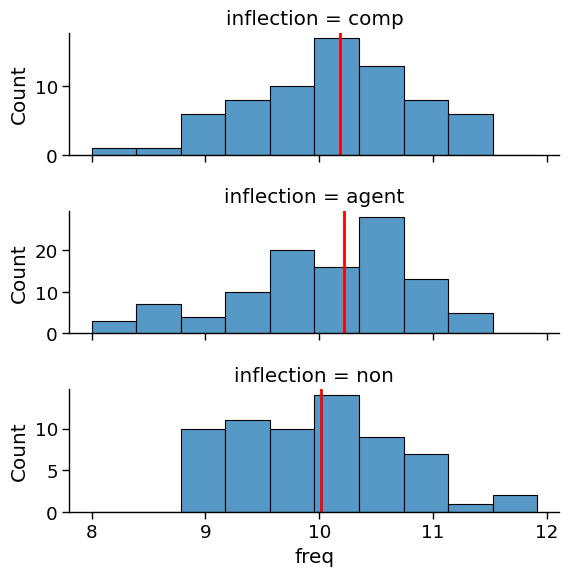

In [134]:
g = sns.displot(data=freq_stats_df, x="freq", row="inflection", kind="hist", bins=10, height=2, aspect=3, facet_kws={"sharey": False})

# plot medians as vline
for ax, row_name in zip(g.axes.flat, g.row_names):
    ax.axvline(freq_stats_df.query("inflection == @row_name").freq.median(), color="red", linewidth=2)

In [135]:
from scipy.stats import ttest_ind
ttest_ind(freq_stats_df.query("inflection == 'comp'").freq,
          freq_stats_df.query("inflection == 'agent'").freq)

TtestResult(statistic=0.5487048395892152, pvalue=0.5839114017217844, df=174.0)

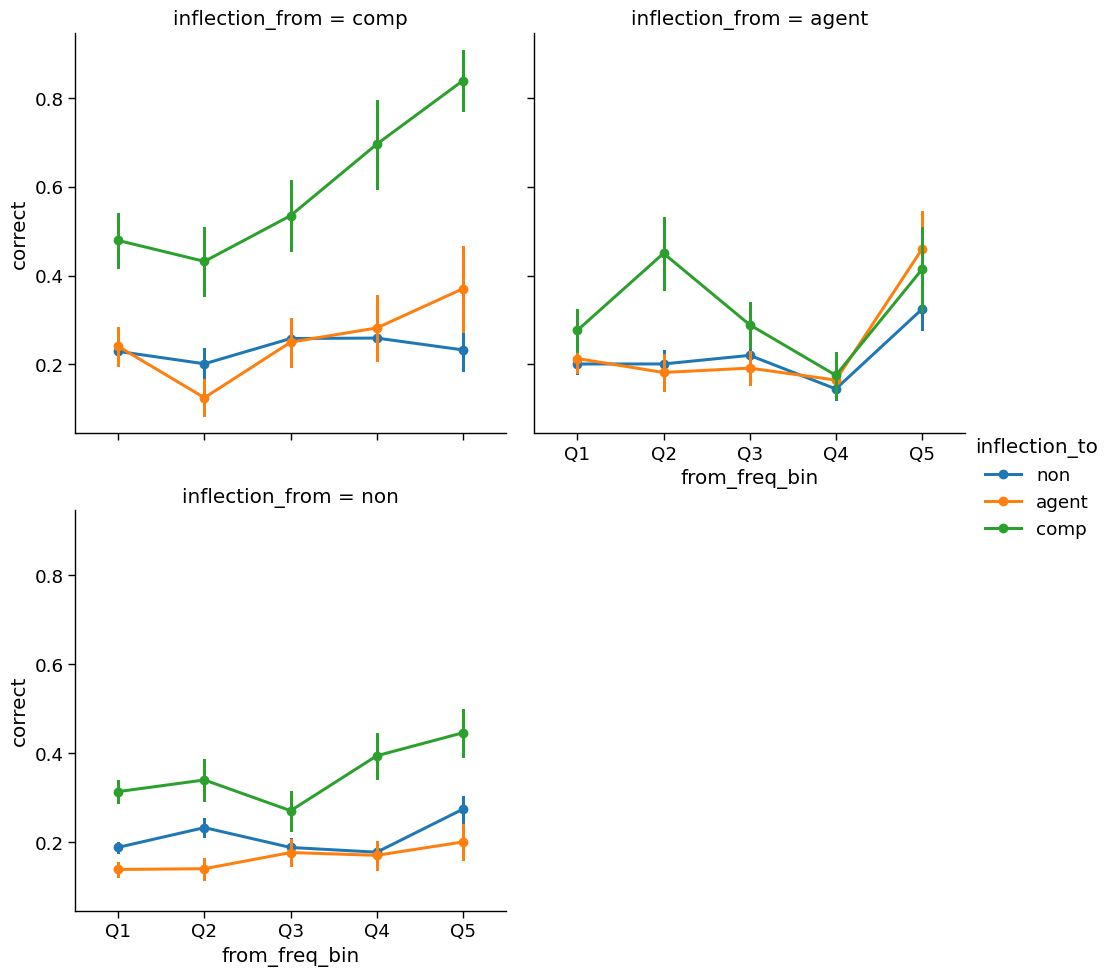

In [136]:
sns.catplot(data=focus_er_results.reset_index(),
            x="from_freq_bin", y="correct", hue="inflection_to",
            col="inflection_from", col_wrap=2, kind="point", errorbar="se")

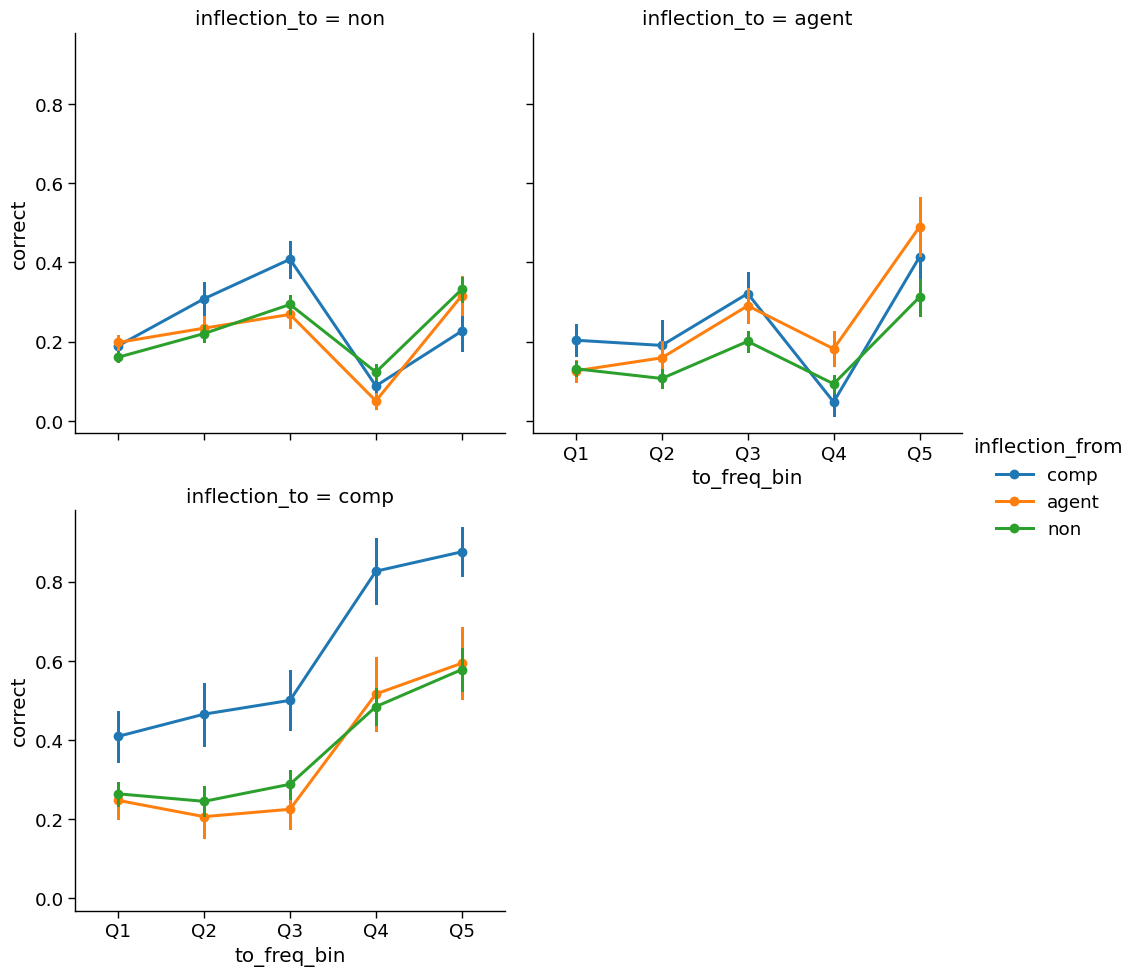

In [137]:
sns.catplot(data=focus_er_results.reset_index(),
            x="to_freq_bin", y="correct", hue="inflection_from",
            col="inflection_to", col_wrap=2, kind="point", errorbar="se")

In [147]:
focus_er_results.query("inflection_to == 'agent'").groupby("base_to").correct.mean().sort_values().head(40)

base_to
ask       0.000000
bake      0.000000
buzz      0.000000
catch     0.000000
tempt     0.000000
charge    0.000000
think     0.000000
till      0.000000
cut       0.000000
dance     0.000000
clip      0.000000
stand     0.000000
fetch     0.000000
eat       0.000000
doubt     0.000000
dig       0.000000
gaze      0.000000
stage     0.000000
serve     0.000000
bid       0.000000
book      0.000000
bloom     0.000000
turn      0.000000
box       0.000000
mend      0.000000
mix       0.000000
pace      0.000000
kill      0.000000
lodge     0.000000
join      0.000000
broke     0.037975
cry       0.045455
hold      0.045455
sneeze    0.052632
stump     0.055556
clap      0.055556
make      0.055556
sin       0.058824
snap      0.058824
fit       0.058824
Name: correct, dtype: float64

In [148]:
focus_er_results.query("base_to == 'sin'").predicted_label.value_counts()

predicted_label
cinder      5
simian      2
sins        2
seamen      1
center      1
cinnamon    1
sandy       1
sooner      1
sinner      1
serene      1
same        1
Name: count, dtype: int64

In [150]:
focus_er_results.query("inflection_to == 'comp'").groupby("base_to").correct.mean().sort_values().head(40)

base_to
flat      0.000000
soft      0.000000
fierce    0.000000
free      0.000000
lame      0.000000
smart     0.000000
scarce    0.000000
rough     0.000000
white     0.000000
weird     0.041667
wet       0.058824
sleek     0.058824
fresh     0.071429
tough     0.105263
steep     0.117647
rare      0.117647
meek      0.120000
cheap     0.125000
strict    0.150000
black     0.153846
smooth    0.153846
wide      0.190476
quaint    0.214286
cold      0.222222
sure      0.227273
keen      0.250000
damp      0.250000
full      0.260870
brave     0.280000
cool      0.307692
slow      0.312500
fond      0.315789
wrong     0.333333
broad     0.333333
kind      0.352941
prompt    0.375000
calm      0.375000
sad       0.400000
nice      0.416667
safe      0.416667
Name: correct, dtype: float64

In [152]:
focus_er_results.query("base_to == 'sad'").predicted_label.value_counts()

predicted_label
sadder       8
sadness      2
sapphire     2
sighted      1
sirens       1
sadly        1
cipher       1
spaniards    1
snapped      1
spaniard     1
sancho       1
Name: count, dtype: int64